In [1]:
import pandas as pd
import os
import s3fs
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import json



# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

BUCKET = "cgadeau/Antoine Airdrop/"
FILE_KEY_S3 = "df_all_clusters_final.csv"
FILE_PATH_S3 = BUCKET + FILE_KEY_S3

with fs.open(FILE_PATH_S3, mode="rb") as file_in:
    dataset = pd.read_csv(file_in, sep=",")

In [ ]:
with fs.open(BUCKET + "df_Données_Reabos_odd_final.csv", mode='rb') as file_in:
    bigdata = pd.read_csv(file_in, sep=',')
print(bigdata['ID_ABONNE'].nunique())

780796


In [2]:
print(dataset['ID_ABONNE'].nunique())
print(dataset.columns)
dataset

78079
Index(['ID_ABONNE', 'DATE_ACTE_REEL', 'DATE_DEMARRAGE_PROMO', 'TYPE_PROMON',
       'STATUT_FIN_M_MOINS_1', 'DATE_PRISE_EFFET', 'DATE_FIN_ABO_PREC',
       'DATE_FIN_REABO', 'REGION', 'FORMULE_PREC', 'FORMULE_REABO',
       'CANAL_DISTRIB', 'ENSEIGNE', 'MOYEN_PAIEMENT', 'REABO_AVANT_ECHEANCE',
       'DELAI_REABO', 'NB_APPARITIONS', 'MOY_DELAI', 'PREMIERE_APPARITION',
       'ANCIENNETE', 'NOMBRE_ABONNEMENTS', 'SCORE_FIDELITE', 'Cluster_8'],
      dtype='object')


,ID_ABONNE,DATE_ACTE_REEL,DATE_DEMARRAGE_PROMO,TYPE_PROMON,STATUT_FIN_M_MOINS_1,DATE_PRISE_EFFET,DATE_FIN_ABO_PREC,DATE_FIN_REABO,REGION,FORMULE_PREC,...,MOYEN_PAIEMENT,REABO_AVANT_ECHEANCE,DELAI_REABO,NB_APPARITIONS,MOY_DELAI,PREMIERE_APPARITION,ANCIENNETE,NOMBRE_ABONNEMENTS,SCORE_FIDELITE,Cluster_8
0,51276418001,2022-06-19,2022-06-19,ODD 30 jours TC,1.0,2022-06-19,2022-05-31,2022-09-18,Sénégal - Divers,AFRIQUE - EVASION & CANAL+,...,Cash,0,19,9,17.111111,2021-02-16,986,"[5, 4]",0.346154,4
1,51276418001,2021-12-01,2021-12-01,ODD 21 jours TC,0.0,2021-12-01,2021-08-23,2022-02-28,Sénégal - Divers,AFRIQUE - EVASION,...,Cash,0,100,9,17.111111,2021-02-16,986,"[5, 4]",0.346154,4
2,51276418001,2021-05-15,2021-05-15,ODD 15 jours TC,1.0,2021-05-15,2021-04-30,2021-06-14,Dakar,AFRIQUE - EVASION & CANAL+,...,Cash,0,15,9,17.111111,2021-02-16,986,"[5, 4]",0.346154,4
3,51276418001,2022-01-16,2022-01-16,ODD 15 jours TC,1.0,2022-03-01,2022-02-28,2022-05-31,Sénégal - Divers,AFRIQUE - EVASION & CANAL+,...,Cash,1,-43,9,17.111111,2021-02-16,986,"[5, 4]",0.346154,4
4,51276418001,2021-07-24,2021-07-24,ODD 15 jours TC,0.0,2021-07-24,2021-06-14,2021-08-23,Dakar,AFRIQUE - EVASION & CANAL+,...,Cash,0,40,9,17.111111,2021-02-16,986,"[5, 4]",0.346154,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946857,51458332904,2021-02-09,2021-02-09,PAS_ODD,1.0,2021-02-09,2021-02-07,2022-02-08,Dakar,AFRIQUE - EVASION & CANAL+,...,Cash,0,2,3,3.666667,2021-02-09,993,"[1, 1, 1]",0.076923,4
946858,51458332904,2023-02-16,2023-02-16,PAS_ODD,1.0,2023-02-16,2023-02-14,2024-02-15,Dakar,AFRIQUE - EVASION & CANAL+,...,Cash,0,2,3,3.666667,2021-02-09,993,"[1, 1, 1]",0.076923,4
946859,51720983201,2021-09-11,2021-10-01,PAS_ODD,1.0,2021-10-01,2021-09-30,2022-09-30,Dakar,AFRIQUE - ACCESS,...,Prélèvement RIB,1,-19,3,-19.000000,2021-09-11,779,"[1, 1, 1]",0.076923,4
946860,51720983201,2022-09-11,2022-10-01,PAS_ODD,1.0,2022-10-01,2022-09-30,2023-09-30,Dakar,AFRIQUE - ACCESS,...,Prélèvement RIB,1,-19,3,-19.000000,2021-09-11,779,"[1, 1, 1]",0.076923,4


In [4]:
def date_bascule(df, cluster):
    data = df.copy()
    data = data.loc[data["Cluster_8"] == cluster]
    data['DATE_PRISE_EFFET'] = pd.to_datetime(data['DATE_PRISE_EFFET'])
    data['ANNEE_MOIS'] = data['DATE_PRISE_EFFET'].dt.strftime('%Y-%m')
    result = data.groupby('ANNEE_MOIS')['ID_ABONNE'].nunique().reset_index()
    result.rename(columns={'ID_ABONNE' : 'NOMBRE_ABONNEMENTS'}, inplace = True)

    def ecart_type_avant_après(dataframe, line):
        result_before = dataframe.iloc[line:]
        result_after = dataframe.iloc[:line]
        std_before = result_before['NOMBRE_ABONNEMENTS'].std()
        mean_before = result_before['NOMBRE_ABONNEMENTS'].mean()
        std_after = result_after['NOMBRE_ABONNEMENTS'].std()
        mean_after = result_after['NOMBRE_ABONNEMENTS'].mean()
        return (std_before, std_after, mean_before, mean_after)

    min_std = float('inf')
    date = None
    min_std_before = None
    min_std_after = None
    the_mean_before = None
    the_mean_after = None
    for line in range(1, result.shape[0]):
        std_before, std_after, mean_before, mean_after = ecart_type_avant_après(result, line)
        std_line = std_before + std_after
        if min_std > std_line:
            min_std = std_line
            min_std_before = std_before
            min_std_after = std_after
            the_mean_before = mean_before
            the_mean_after = mean_after
            date = line
    
    ratio = the_mean_before/the_mean_after
    if ratio > 19/20 and ratio < 20/19 :
        date = None
        min_std_before = None
        min_std_after = None
        the_mean_before = None
        the_mean_after = None

    if date != None :
        mois_bascule = result.loc[date, 'ANNEE_MOIS']
        print('Date = ', mois_bascule)
    else :
        print('Date = ', date)
    print('Std error before = ', min_std_before)
    print('Std error after = ', min_std_after)
    print('Mean before = ', the_mean_before)
    print('Mean after = ', the_mean_after)
    print('Ecart des moyennes = ')

    return(result, mois_bascule)

liste_bascule = []
for i in range (0, 8, 1):
    print(i)
    liste_bascule += [date_bascule(dataset, i)[1]]
print(liste_bascule)

0
Date =  2021-09
Std error before =  1314.2953566894257
Std error after =  38.18376618407357
Mean before =  2388.730769230769
Mean after =  29.0
Ecart des moyennes = 
1
Date =  2022-07
Std error before =  419.1377607660756
Std error after =  772.4214789714683
Mean before =  1311.0625
Mean after =  3624.6666666666665
Ecart des moyennes = 
2
Date =  2021-07
Std error before =  2442.5056857932336
Std error after =  1716.4049250298328
Mean before =  4346.892857142857
Mean after =  3240.3333333333335
Ecart des moyennes = 
3
Date =  2021-05
Std error before =  1470.3906103911427
Std error after =  742.9762221408345
Mean before =  6352.933333333333
Mean after =  4773.5
Ecart des moyennes = 
4
Date =  2023-04
Std error before =  343.11992905438433
Std error after =  1470.2171041493611
Mean before =  1050.5714285714287
Mean after =  2456.222222222222
Ecart des moyennes = 
5
Date =  2021-12
Std error before =  1998.8416260048725
Std error after =  69.37518768743381
Mean before =  3958.130434782

In [5]:
def find_periods(df, cluster):

    data = df.copy()
    data = data.loc[data["Cluster_8"] == cluster]
    data['DATE_PRISE_EFFET'] = pd.to_datetime(data['DATE_PRISE_EFFET'])
    result = data.groupby(['DATE_PRISE_EFFET', 'TYPE_PROMON'])['ID_ABONNE'].nunique().reset_index()
    result.rename(columns={'ID_ABONNE' : 'NOMBRE_ABONNEMENTS'}, inplace = True)

    
    
    # Calculer la moyenne mobile sur une fenêtre glissante pour chaque TYPE_PROMON
    window_size = 7  # Taille de la fenêtre glissante pour la moyenne mobile
    df['rolling_mean'] = df.groupby('TYPE_PROMON')['NOMBRE_ABONNEMENTS'].transform(lambda x: x.rolling(window_size).mean())

    # Identifier les périodes où une promotion est significativement plus élevée que les autres
    # Par exemple, vous pouvez définir un seuil pour déterminer ce qui constitue une augmentation significative
    seuil = 1.5  # Changer cela selon vos besoins
    promotions_significatives = df[df['NOMBRE_ABONNEMENTS'] > seuil * df['rolling_mean']]

    # Afficher les dates qui délimitent ces périodes
    dates_limites = promotions_significatives['DATE_PRISE_EFFET'].unique()

    print("Les dates limites des périodes où une promotion est significativement plus utilisée que les autres sont :", dates_limites)


    return result


find_periods(dataset, 0)

DataError: No numeric types to aggregate

In [3]:
def create_dataset_all_dates(df, cluster):

    data = df.copy()
    data = data.loc[data["Cluster_8"] == cluster]
    """
    data.rename(columns={'DATE_PRISE_EFFET' : 'NOUVEAU_NOM'}, inplace = True)
    data.rename(columns={'DATE_ACTE_REEL' : 'DATE_PRISE_EFFET'}, inplace = True)
    """
    data['DATE_PRISE_EFFET'] = pd.to_datetime(data['DATE_PRISE_EFFET'])
    result = data.groupby(['DATE_PRISE_EFFET', 'TYPE_PROMON'])['ID_ABONNE'].nunique().reset_index()
    result.rename(columns={'ID_ABONNE' : 'NOMBRE_ABONNEMENTS'}, inplace = True)

    
    # Création d'un DataFrame contenant toutes les dates et tous les types promon possibles
    min_date = result['DATE_PRISE_EFFET'].min()
    max_date = result['DATE_PRISE_EFFET'].max()
    all_dates = pd.date_range(start=min_date, end=max_date, freq='D')
    all_promotions = result['TYPE_PROMON'].unique()
    all_possible_combinations = pd.MultiIndex.from_product([all_dates, all_promotions], names=['DATE_PRISE_EFFET', 'TYPE_PROMON'])
    df_all_combinations = pd.DataFrame(index=all_possible_combinations).reset_index()

    # Fusion avec votre DataFrame initial pour remplir les valeurs manquantes
    merged_df = pd.merge(df_all_combinations, result, on=['DATE_PRISE_EFFET', 'TYPE_PROMON'], how='left')

    # Remplacement des valeurs manquantes de NOMBRE_ABONNEMENTS par 0
    merged_df['NOMBRE_ABONNEMENTS'] = merged_df['NOMBRE_ABONNEMENTS'].fillna(0)

    return merged_df
print(create_dataset_all_dates(dataset, 0))
create_dataset_all_dates(dataset, 0)


     DATE_PRISE_EFFET               TYPE_PROMON  NOMBRE_ABONNEMENTS
0          2021-07-30           ODD 15 jours TC                 2.0
1          2021-07-30  ODD 7 jours autre que SG                 0.0
2          2021-07-30          ODD 15 jours EV+                 0.0
3          2021-07-30         Semaine genéreuse                 0.0
4          2021-07-30           ODD 21 jours TC                 0.0
...               ...                       ...                 ...
7411       2023-10-31           ODD 21 jours TC                13.0
7412       2023-10-31           ODD 30 jours TC                 0.0
7413       2023-10-31                   PAS_ODD                 0.0
7414       2023-10-31          ODD 30 jours EV+                 0.0
7415       2023-10-31                    Autres                 0.0

[7416 rows x 3 columns]


,DATE_PRISE_EFFET,TYPE_PROMON,NOMBRE_ABONNEMENTS
0,2021-07-30,ODD 15 jours TC,2.0
1,2021-07-30,ODD 7 jours autre que SG,0.0
2,2021-07-30,ODD 15 jours EV+,0.0
3,2021-07-30,Semaine genéreuse,0.0
4,2021-07-30,ODD 21 jours TC,0.0
...,...,...,...
7411,2023-10-31,ODD 21 jours TC,13.0
7412,2023-10-31,ODD 30 jours TC,0.0
7413,2023-10-31,PAS_ODD,0.0
7414,2023-10-31,ODD 30 jours EV+,0.0


In [4]:
def find_periods(data, cluster):
    df = create_dataset_all_dates(data, cluster)

    # Étape 1 : Identifier les périodes où le nombre d'abonnements est significativement plus élevé que la moyenne ou la médiane
    periodes_significatives = {}
    for promotion, series in df.groupby('TYPE_PROMON'):
        # Calculer la moyenne ou la médiane de la série temporelle
        mean = series['NOMBRE_ABONNEMENTS'].mean()
        # Remplacer mean par median pour utiliser la médiane
        std = series['NOMBRE_ABONNEMENTS'].std()
        seuil = mean + 2 * std  # Choisir un seuil approprié en fonction de votre analyse
        # Identifier les périodes où le nombre d'abonnements dépasse le seuil
        periodes_significatives[promotion] = series[series['NOMBRE_ABONNEMENTS'] > seuil]

    # Étape 2 : Fusionner les périodes consécutives avec le même TYPE_PROMON
    merged_periodes = {}
    for promotion, periodes in periodes_significatives.items():
        current_start = None
        current_end = None
        for index, row in periodes.iterrows():
            if current_start is None:
                current_start = row['DATE_PRISE_EFFET']
                current_end = row['DATE_PRISE_EFFET']
            elif row['DATE_PRISE_EFFET'] == current_end + pd.Timedelta(days=1):
                current_end = row['DATE_PRISE_EFFET']
            else:
                if promotion not in merged_periodes:
                    merged_periodes[promotion] = []
                merged_periodes[promotion].append((current_start, current_end))
                current_start = row['DATE_PRISE_EFFET']
                current_end = row['DATE_PRISE_EFFET']
        if current_start is not None:
            if promotion not in merged_periodes:
                merged_periodes[promotion] = []
            merged_periodes[promotion].append((current_start, current_end))

    # Étape 3 : Fusionner les périodes qui se chevauchent avec des TYPE_PROMON différents
    final_periodes = []
    for promotion, periodes in merged_periodes.items():
        for periode in periodes:
            if not final_periodes:
                final_periodes.append((promotion, periode[0], periode[1]))
            else:
                last_promotion, last_start, last_end = final_periodes[-1]
                if last_end >= periode[0] and last_promotion != promotion:
                    final_periodes[-1] = (last_promotion + " / " + promotion, min(last_start, periode[0]), max(last_end, periode[1]))
                else:
                    final_periodes.append((promotion, periode[0], periode[1]))

    # Étape 4 : Affichez les périodes résultantes avec les TYPE_PROMON et les nombres d'abonnements associés
    for promotion, debut_periode, fin_periode in final_periodes:
        periode_df = df[(df['DATE_PRISE_EFFET'] >= debut_periode) & (df['DATE_PRISE_EFFET'] <= fin_periode) & (df['TYPE_PROMON'].str.contains(promotion))]
        total_abonnements = periode_df['NOMBRE_ABONNEMENTS'].sum()
        print(f"Période significative pour {promotion} du {debut_periode} au {fin_periode}, Nombre total d'abonnements : {total_abonnements}")
    return

for i in range (0, 8, 1):
    find_periods(dataset, i)

Période significative pour Autres du 2022-06-02 00:00:00 au 2022-06-10 00:00:00, Nombre total d'abonnements : 165.0
Période significative pour Autres du 2022-06-12 00:00:00 au 2022-06-22 00:00:00, Nombre total d'abonnements : 110.0
Période significative pour Autres du 2022-06-25 00:00:00 au 2022-06-30 00:00:00, Nombre total d'abonnements : 58.0
Période significative pour Autres / ODD 15 jours EV+ / ODD 15 jours EV+ / ODD 15 jours EV+ / ODD 15 jours EV+ / ODD 15 jours EV+ / ODD 15 jours EV+ / ODD 15 jours EV+ / ODD 15 jours EV+ / ODD 15 jours EV+ / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC du 2022-01-01 00:00:00 au 2023-08-01 00:00:00, Nombre total d'abonnements : 0.0
Période significative pour ODD 15 jours TC /

On va faire le tableau d'Antoine

In [2]:
def find_percent(df):
    """
    Détermine le pourcentage d'abonnés dans le cluster
    """
    data = df.copy()
    total_abonnes = data['ID_ABONNE'].nunique()

    pourcentages_clusters = {}
    for cluster in range(0, 8, 1):
        abonnes_cluster = data[data['Cluster_8'] == cluster]['ID_ABONNE'].nunique()
        pourcentage_cluster = (abonnes_cluster / total_abonnes) * 100
        pourcentages_clusters[cluster] = pourcentage_cluster

    # Afficher les pourcentages associés à chaque cluster
    for cluster, pourcentage in pourcentages_clusters.items():
        print(f"Cluster {cluster}: {pourcentage:.2f}%")
    return pourcentages_clusters

find_percent(dataset)

Cluster 0: 13.45%
Cluster 1: 9.04%
Cluster 2: 14.02%
Cluster 3: 13.07%
Cluster 4: 16.04%
Cluster 5: 10.96%
Cluster 6: 11.96%
Cluster 7: 11.47%


{0: 13.446637380089395,
 1: 9.035720232072645,
 2: 14.016572958157763,
 3: 13.066253410007814,
 4: 16.040164448827472,
 5: 10.963255164640941,
 6: 11.95840110657155,
 7: 11.472995299632425}

In [3]:
def create_periods(date_debut, nb_periods, periode_length_months):
    """Crée les périodes en fonction de la date de début, du nombre de périodes et de la longueur de chaque période en mois."""
    periods = []
    for i in range(nb_periods):
        debut_periode = date_debut + timedelta(days=periode_length_months * 30 * i)
        fin_periode = debut_periode + timedelta(days=periode_length_months * 30)
        periods += [(debut_periode, fin_periode)]
    return periods

def calculate_abonnements_moyens(datata, periods):
    """Calcule le nombre d'abonnements moyens par jour de disponibilité pour chaque cluster sur chaque période."""
    df = datata.copy()
    df['DATE_PRISE_EFFET'] = pd.to_datetime(df['DATE_PRISE_EFFET'])
    nombre_abonnements_moyens = {}
    for cluster, group in df.groupby('Cluster_8'):
        cluster_abonnements_moyens = {}
        for i, (debut_periode, fin_periode) in enumerate(periods, start=1):
            print('Cluster ', cluster, 'période ', i, (debut_periode, fin_periode))
            periode_data = group[(group['DATE_PRISE_EFFET'] >= debut_periode) & (group['DATE_PRISE_EFFET'] < fin_periode)]
            #abonnements_periode = periode_data.groupby('ID_ABONNE')['DATE_PRISE_EFFET'].nunique().count()
            abonnements_periode = periode_data.shape[0]
            print('abonnements_periode :',abonnements_periode)
            if i < 6:
                jours_disponibilite = 6 * periode_data['ID_ABONNE'].nunique()
            elif i == 6:
                jours_disponibilite = 4 * periode_data['ID_ABONNE'].nunique()

            print('jours_disponibilite : ', jours_disponibilite)
            if jours_disponibilite > 0:
                abonnements_moyens_periode = abonnements_periode / jours_disponibilite
            else:
                abonnements_moyens_periode = 0
            cluster_abonnements_moyens[f'Période {i}'] = abonnements_moyens_periode
        nombre_abonnements_moyens[cluster] = cluster_abonnements_moyens
    return nombre_abonnements_moyens

# Définir la date de début et le nombre de périodes
date_debut = datetime.strptime('2021-01-01', '%Y-%m-%d')
nb_periods = 6
periode_length_months = 6

# Créer les périodes
periods = create_periods(date_debut, nb_periods, periode_length_months)
print(periods)

calculate_abonnements_moyens(dataset, periods)


[(datetime.datetime(2021, 1, 1, 0, 0), datetime.datetime(2021, 6, 30, 0, 0)), (datetime.datetime(2021, 6, 30, 0, 0), datetime.datetime(2021, 12, 27, 0, 0)), (datetime.datetime(2021, 12, 27, 0, 0), datetime.datetime(2022, 6, 25, 0, 0)), (datetime.datetime(2022, 6, 25, 0, 0), datetime.datetime(2022, 12, 22, 0, 0)), (datetime.datetime(2022, 12, 22, 0, 0), datetime.datetime(2023, 6, 20, 0, 0)), (datetime.datetime(2023, 6, 20, 0, 0), datetime.datetime(2023, 12, 17, 0, 0))]
Cluster  0 période  1 (datetime.datetime(2021, 1, 1, 0, 0), datetime.datetime(2021, 6, 30, 0, 0))
abonnements_periode : 0
jours_disponibilite :  0
Cluster  0 période  2 (datetime.datetime(2021, 6, 30, 0, 0), datetime.datetime(2021, 12, 27, 0, 0))
abonnements_periode : 3504
jours_disponibilite :  14310
Cluster  0 période  3 (datetime.datetime(2021, 12, 27, 0, 0), datetime.datetime(2022, 6, 25, 0, 0))
abonnements_periode : 16850
jours_disponibilite :  49392
Cluster  0 période  4 (datetime.datetime(2022, 6, 25, 0, 0), dateti

{0: {'Période 1': 0,
  'Période 2': 0.2448637316561845,
  'Période 3': 0.3411483641075478,
  'Période 4': 0.33732601962759806,
  'Période 5': 0.3588232607007446,
  'Période 6': 0.3783490566037736},
 1: {'Période 1': 0.6908693540553666,
  'Période 2': 0.550201417571771,
  'Période 3': 0.5680896271972184,
  'Période 4': 0.4370940170940171,
  'Période 5': 0.4597405775819873,
  'Période 6': 0.5268630849220104},
 2: {'Période 1': 0.4029274200283972,
  'Période 2': 0.38376507744515004,
  'Période 3': 0.4705891634321058,
  'Période 4': 0.42605400284225486,
  'Période 5': 0.47395110670630985,
  'Période 6': 0.43076628841004716},
 3: {'Période 1': 0.638110790101746,
  'Période 2': 0.5973631178057861,
  'Période 3': 0.7108356380877123,
  'Période 4': 0.6265542328042328,
  'Période 5': 0.689389338731444,
  'Période 6': 0.6456884561891516},
 4: {'Période 1': 0.35348183037320513,
  'Période 2': 0.2861167940849216,
  'Période 3': 0.3015029247256735,
  'Période 4': 0.2641629535327817,
  'Période 5': 

In [3]:
def find_mean_with_promo(df):
    data = df.copy()
    # Grouper les données par CLUSTER_8 et TYPE_PROMON
    grouped_data = data.groupby(['Cluster_8', 'TYPE_PROMON'])

    # Initialiser des dictionnaires pour stocker les résultats
    nombre_interventions = {}
    nombre_dates_differentes = {}
    nombre_reabo_par_jour_dispo = {}

    # Boucler à travers chaque groupe
    for (cluster, type_promo), group in grouped_data:
        # Nombre de fois que TYPE_PROMON i intervient dans le cluster_8 j
        nombre_intervention = len(group)
        # Nombre de DATE_PRISE_EFFET différentes auxquelles TYPE_PROMON i intervient dans le cluster_8 j
        nombre_dates_diff = group['DATE_PRISE_EFFET'].nunique()
        
        # Stocker les résultats dans les dictionnaires
        if cluster not in nombre_interventions:
            nombre_interventions[cluster] = {}
            nombre_dates_differentes[cluster] = {}
            nombre_reabo_par_jour_dispo[cluster] = {}
        nombre_interventions[cluster][type_promo] = nombre_intervention
        nombre_dates_differentes[cluster][type_promo] = nombre_dates_diff
        nombre_reabo_par_jour_dispo[cluster][type_promo] = nombre_intervention/nombre_dates_diff

    # Afficher les résultats
    for cluster, interventions in nombre_interventions.items():
        print(f"Cluster {cluster}:")
        for type_promo, nb_interventions in interventions.items():
            nb_dates_diff = nombre_dates_differentes[cluster][type_promo]
            print(f"  - Type promotion {type_promo}:")
            #print(f"      Nombre d'interventions : {nb_interventions}")
            #print(f"      Nombre de dates différentes : {nb_dates_diff}")
            print(f"      Nombre de réabonnements moyens par jour de disponibilité : {nb_interventions/nb_dates_diff}")
    return nombre_reabo_par_jour_dispo

find_mean_with_promo(dataset)

Cluster 0:
  - Type promotion Autres:
      Nombre de réabonnements moyens par jour de disponibilité : 6.5
  - Type promotion ODD 15 jours EV+:
      Nombre de réabonnements moyens par jour de disponibilité : 2.8225806451612905
  - Type promotion ODD 15 jours TC:
      Nombre de réabonnements moyens par jour de disponibilité : 55.17304189435337
  - Type promotion ODD 21 jours TC:
      Nombre de réabonnements moyens par jour de disponibilité : 11.206030150753769
  - Type promotion ODD 30 jours EV+:
      Nombre de réabonnements moyens par jour de disponibilité : 19.560439560439562
  - Type promotion ODD 30 jours TC:
      Nombre de réabonnements moyens par jour de disponibilité : 13.387434554973822
  - Type promotion ODD 7 jours autre que SG:
      Nombre de réabonnements moyens par jour de disponibilité : 6.732342007434944
  - Type promotion PAS_ODD:
      Nombre de réabonnements moyens par jour de disponibilité : 15.927272727272728
  - Type promotion Semaine genéreuse:
      Nombre d

{0: {'Autres': 6.5,
  'ODD 15 jours EV+': 2.8225806451612905,
  'ODD 15 jours TC': 55.17304189435337,
  'ODD 21 jours TC': 11.206030150753769,
  'ODD 30 jours EV+': 19.560439560439562,
  'ODD 30 jours TC': 13.387434554973822,
  'ODD 7 jours autre que SG': 6.732342007434944,
  'PAS_ODD': 15.927272727272728,
  'Semaine genéreuse': 17.189228529839884},
 1: {'Autres': 5.051282051282051,
  'ODD 15 jours EV+': 6.784722222222222,
  'ODD 15 jours TC': 36.646814404432135,
  'ODD 21 jours TC': 3.890932982917214,
  'ODD 30 jours EV+': 11.285123966942148,
  'ODD 30 jours TC': 10.476190476190476,
  'ODD 7 jours autre que SG': 1.651685393258427,
  'PAS_ODD': 15.5546875,
  'Semaine genéreuse': 49.26271186440678},
 2: {'Autres': 11.012820512820513,
  'ODD 15 jours EV+': 9.801204819277109,
  'ODD 15 jours TC': 106.06803594351733,
  'ODD 21 jours TC': 5.796653796653796,
  'ODD 30 jours EV+': 25.765690376569037,
  'ODD 30 jours TC': 22.948529411764707,
  'ODD 7 jours autre que SG': 2.638888888888889,
  '

In [4]:
def find_mean_with_promo_periods(df, periods):
    print(periods)
    data = df.copy()
    data['DATE_PRISE_EFFET'] = pd.to_datetime(data['DATE_PRISE_EFFET'])

    # Grouper les données par CLUSTER_8, TYPE_PROMON et Période
    nombre_reabo_par_jour_dispo = {}
    for (cluster, type_promo), group in data.groupby(['Cluster_8', 'TYPE_PROMON']):
        cluster_abonnements_moyens = {}
        for i, (debut_periode, fin_periode) in enumerate(periods, start=1):
            periode_data = group[(group['DATE_PRISE_EFFET'] >= debut_periode) & (group['DATE_PRISE_EFFET'] < fin_periode)]
            abonnements_periode = len(periode_data)
            dates_diff = periode_data['DATE_PRISE_EFFET'].nunique()
            if dates_diff > 0:
                abonnements_moyens_periode = abonnements_periode / dates_diff
            else:
                abonnements_moyens_periode = 0
            cluster_abonnements_moyens[f'Période {i}'] = abonnements_moyens_periode
        if cluster not in nombre_reabo_par_jour_dispo:
            nombre_reabo_par_jour_dispo[cluster] = {}
        nombre_reabo_par_jour_dispo[cluster][type_promo] = cluster_abonnements_moyens

    # Afficher les résultats
    for cluster, resultats_periode in nombre_reabo_par_jour_dispo.items():
        print(f"Cluster {cluster}:")
        for type_promo, resultats_periode_type in resultats_periode.items():
            print(f"  - Type promotion {type_promo}:")
            for periode, moyenne in resultats_periode_type.items():
                print(f"      Période {periode}: Nombre de réabonnements moyens par jour de disponibilité : {moyenne}")
    return nombre_reabo_par_jour_dispo

# Appeler la fonction pour calculer les abonnements moyens
find_mean_with_promo_periods(dataset, periods)

[(datetime.datetime(2021, 1, 1, 0, 0), datetime.datetime(2021, 6, 30, 0, 0)), (datetime.datetime(2021, 6, 30, 0, 0), datetime.datetime(2021, 12, 27, 0, 0)), (datetime.datetime(2021, 12, 27, 0, 0), datetime.datetime(2022, 6, 25, 0, 0)), (datetime.datetime(2022, 6, 25, 0, 0), datetime.datetime(2022, 12, 22, 0, 0)), (datetime.datetime(2022, 12, 22, 0, 0), datetime.datetime(2023, 6, 20, 0, 0)), (datetime.datetime(2023, 6, 20, 0, 0), datetime.datetime(2023, 12, 17, 0, 0))]
Cluster 0:
  - Type promotion Autres:
      Période Période 1: Nombre de réabonnements moyens par jour de disponibilité : 0
      Période Période 2: Nombre de réabonnements moyens par jour de disponibilité : 0
      Période Période 3: Nombre de réabonnements moyens par jour de disponibilité : 12.25
      Période Période 4: Nombre de réabonnements moyens par jour de disponibilité : 6.6
      Période Période 5: Nombre de réabonnements moyens par jour de disponibilité : 0
      Période Période 6: Nombre de réabonnements moye

{0: {'Autres': {'Période 1': 0,
   'Période 2': 0,
   'Période 3': 12.25,
   'Période 4': 6.6,
   'Période 5': 0,
   'Période 6': 1.8666666666666667},
  'ODD 15 jours EV+': {'Période 1': 0,
   'Période 2': 1.9649122807017543,
   'Période 3': 3.049586776859504,
   'Période 4': 3.276190476190476,
   'Période 5': 2.8955223880597014,
   'Période 6': 1.4090909090909092},
  'ODD 15 jours TC': {'Période 1': 0,
   'Période 2': 28.406779661016948,
   'Période 3': 35.162962962962965,
   'Période 4': 88.1842105263158,
   'Période 5': 65.23448275862069,
   'Période 6': 45.364583333333336},
  'ODD 21 jours TC': {'Période 1': 0,
   'Période 2': 6.308943089430894,
   'Période 3': 9.63888888888889,
   'Période 4': 15.155555555555555,
   'Période 5': 10.720670391061452,
   'Période 6': 13.149253731343284},
  'ODD 30 jours EV+': {'Période 1': 0,
   'Période 2': 0,
   'Période 3': 27.66315789473684,
   'Période 4': 12.80281690140845,
   'Période 5': 0,
   'Période 6': 1.4375},
  'ODD 30 jours TC': {'Péri

On crée le df qui regroupe toutes les informations

In [7]:
dataset_cluster_explanations = pd.DataFrame({'Cluster': list(range(8))})

dataset_cluster_explanations['Pourcentage de la population'] = dataset_cluster_explanations['Cluster'].map(find_percent(dataset))
dataset_cluster_explanations["Dico"] = dataset_cluster_explanations['Cluster'].map(find_mean_with_promo_periods(dataset, periods))
print(dataset['TYPE_PROMON'].unique())
for i in range(1, 7, 1):
    for promo in dataset['TYPE_PROMON'].unique():
        dataset_cluster_explanations[f"Facteur d'abonnement pour {promo} sur la période {i}"] = dataset_cluster_explanations["Dico"].apply(lambda x: x[promo][f"Période {i}"])

for promo in dataset['TYPE_PROMON'].unique():
    for i in range(1, 7, 1):
        if not dataset_cluster_explanations[f"Facteur d'abonnement pour Semaine genéreuse sur la période {i}"].empty :
            dataset_cluster_explanations[f"Facteur d'abonnement pour {promo} sur la période {i}"] = dataset_cluster_explanations[f"Facteur d'abonnement pour {promo} sur la période {i}"] / dataset_cluster_explanations[f"Facteur d'abonnement pour Semaine genéreuse sur la période {i}"]
        else :
            dataset_cluster_explanations[f"Facteur d'abonnement pour {promo} sur la période {i}"] = float('inf')

dataset_cluster_explanations.drop(columns = ['Dico'], inplace = True)

dataset_cluster_explanations["Periods"] = dataset_cluster_explanations['Cluster'].map(calculate_abonnements_moyens(dataset, periods))
print(dataset_cluster_explanations)
for i in range(1, 7, 1):
    dataset_cluster_explanations[f"Taux d'abonnement sur la période {i}"] = dataset_cluster_explanations["Periods"].apply(lambda x: x[f"Période {i}"])
dataset_cluster_explanations.drop(columns = ['Periods'], inplace = True)
dataset_cluster_explanations = dataset_cluster_explanations.fillna(0)
dataset_cluster_explanations = dataset_cluster_explanations.round(1)

# Enregistrer la figure dans un fichier
nom_fichier_temporaire = 'clusters_explanation.csv'
dataset_cluster_explanations.to_csv(nom_fichier_temporaire, index=False)
# Enregistrer le fichier temporaire sur S3
with fs.open(BUCKET + nom_fichier_temporaire, mode='wb') as file_out:
    with open(nom_fichier_temporaire, 'rb') as temp_file:
        file_out.write(temp_file.read())
# Supprimer le fichier temporaire
os.remove(nom_fichier_temporaire)

dataset_cluster_explanations

Cluster 0: 13.45%
Cluster 1: 9.04%
Cluster 2: 14.02%
Cluster 3: 13.07%
Cluster 4: 16.04%
Cluster 5: 10.96%
Cluster 6: 11.96%
Cluster 7: 11.47%
[(datetime.datetime(2021, 1, 1, 0, 0), datetime.datetime(2021, 6, 30, 0, 0)), (datetime.datetime(2021, 6, 30, 0, 0), datetime.datetime(2021, 12, 27, 0, 0)), (datetime.datetime(2021, 12, 27, 0, 0), datetime.datetime(2022, 6, 25, 0, 0)), (datetime.datetime(2022, 6, 25, 0, 0), datetime.datetime(2022, 12, 22, 0, 0)), (datetime.datetime(2022, 12, 22, 0, 0), datetime.datetime(2023, 6, 20, 0, 0)), (datetime.datetime(2023, 6, 20, 0, 0), datetime.datetime(2023, 12, 17, 0, 0))]
Cluster 0:
  - Type promotion Autres:
      Période Période 1: Nombre de réabonnements moyens par jour de disponibilité : 0
      Période Période 2: Nombre de réabonnements moyens par jour de disponibilité : 0
      Période Période 3: Nombre de réabonnements moyens par jour de disponibilité : 12.25
      Période Période 4: Nombre de réabonnements moyens par jour de disponibilité : 

,Cluster,Pourcentage de la population,Facteur d'abonnement pour ODD 30 jours TC sur la période 1,Facteur d'abonnement pour ODD 21 jours TC sur la période 1,Facteur d'abonnement pour ODD 15 jours TC sur la période 1,Facteur d'abonnement pour Semaine genéreuse sur la période 1,Facteur d'abonnement pour PAS_ODD sur la période 1,Facteur d'abonnement pour ODD 7 jours autre que SG sur la période 1,Facteur d'abonnement pour ODD 15 jours EV+ sur la période 1,Facteur d'abonnement pour ODD 30 jours EV+ sur la période 1,...,Facteur d'abonnement pour ODD 7 jours autre que SG sur la période 6,Facteur d'abonnement pour ODD 15 jours EV+ sur la période 6,Facteur d'abonnement pour ODD 30 jours EV+ sur la période 6,Facteur d'abonnement pour Autres sur la période 6,Taux d'abonnement sur la période 1,Taux d'abonnement sur la période 2,Taux d'abonnement sur la période 3,Taux d'abonnement sur la période 4,Taux d'abonnement sur la période 5,Taux d'abonnement sur la période 6
0,0,13.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.4,1.4,1.9,0.0,0.2,0.3,0.3,0.4,0.4
1,1,9.0,0.2,0.0,0.4,1.0,1.3,1.8,14.1,9.7,...,0.0,1.2,1.7,2.6,0.7,0.6,0.6,0.4,0.5,0.5
2,2,14.0,0.5,0.0,1.3,1.0,1.3,2.2,24.0,9.1,...,0.0,1.4,2.3,3.3,0.4,0.4,0.5,0.4,0.5,0.4
3,3,13.1,0.2,0.0,0.4,1.0,1.3,1.8,16.3,11.0,...,0.0,1.2,6.0,6.7,0.6,0.6,0.7,0.6,0.7,0.6
4,4,16.0,0.3,0.0,1.1,1.0,2.0,3.8,25.7,9.4,...,0.0,1.3,1.2,1.7,0.4,0.3,0.3,0.3,0.3,0.4
5,5,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,5.2,7.2,0.0,0.2,0.5,0.5,0.7,0.7
6,6,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.7,9.4,2.3,3.9,0.0,0.0,0.2,0.3,0.4,0.5
7,7,11.5,0.1,0.0,0.3,1.0,1.4,1.4,12.0,12.5,...,0.0,1.0,8.2,7.6,0.8,0.8,0.9,0.8,0.8,0.8


In [8]:
dataset_cluster_explanations = pd.DataFrame({'Cluster': list(range(8))})


dataset_cluster_explanations['Pourcentage de la population'] = dataset_cluster_explanations['Cluster'].map(find_percent(dataset))
dataset_cluster_explanations["Dico"] = dataset_cluster_explanations['Cluster'].map(find_mean_with_promo_periods(dataset, periods))
print(dataset_cluster_explanations["Dico"])
print(dataset['TYPE_PROMON'].unique())
for i in range(1, 7, 1):
    for promo in ['Semaine genéreuse', 'ODD 15 jours TC', 'ODD 30 jours TC']:
        dataset_cluster_explanations[f"Facteur d'abonnement pour {promo} sur la période {i}"] = dataset_cluster_explanations["Dico"].apply(lambda x: x[promo][f"Période {i}"])

for promo in ['Semaine genéreuse', 'ODD 15 jours TC', 'ODD 30 jours TC']:
    for i in range(1, 7, 1):
        if not dataset_cluster_explanations[f"Facteur d'abonnement pour Semaine genéreuse sur la période {i}"].empty :
            dataset_cluster_explanations[f"Facteur d'abonnement pour {promo} sur la période {i}"] = dataset_cluster_explanations[f"Facteur d'abonnement pour {promo} sur la période {i}"] / dataset_cluster_explanations[f"Facteur d'abonnement pour Semaine genéreuse sur la période {i}"]
        else :
            dataset_cluster_explanations[f"Facteur d'abonnement pour {promo} sur la période {i}"] = float('inf')

dataset_cluster_explanations.drop(columns = ['Dico'], inplace = True)

dataset_cluster_explanations["Periods"] = dataset_cluster_explanations['Cluster'].map(calculate_abonnements_moyens(dataset, periods))
print(dataset_cluster_explanations)
for i in range(1, 7, 1):
    dataset_cluster_explanations[f"Taux d'abonnement sur la période {i}"] = dataset_cluster_explanations["Periods"].apply(lambda x: x[f"Période {i}"])
dataset_cluster_explanations.drop(columns = ['Periods'], inplace = True)
dataset_cluster_explanations = dataset_cluster_explanations.fillna(0)
dataset_cluster_explanations = dataset_cluster_explanations.round(1)

# Enregistrer la figure dans un fichier
nom_fichier_temporaire = 'clusters_explanation_shortened_2.csv'
dataset_cluster_explanations.to_csv(nom_fichier_temporaire, index=False)
# Enregistrer le fichier temporaire sur S3
with fs.open(BUCKET + nom_fichier_temporaire, mode='wb') as file_out:
    with open(nom_fichier_temporaire, 'rb') as temp_file:
        file_out.write(temp_file.read())
# Supprimer le fichier temporaire
os.remove(nom_fichier_temporaire)

dataset_cluster_explanations

Cluster 0: 13.45%
Cluster 1: 9.04%
Cluster 2: 14.02%
Cluster 3: 13.07%
Cluster 4: 16.04%
Cluster 5: 10.96%
Cluster 6: 11.96%
Cluster 7: 11.47%
[(datetime.datetime(2021, 1, 1, 0, 0), datetime.datetime(2021, 6, 30, 0, 0)), (datetime.datetime(2021, 6, 30, 0, 0), datetime.datetime(2021, 12, 27, 0, 0)), (datetime.datetime(2021, 12, 27, 0, 0), datetime.datetime(2022, 6, 25, 0, 0)), (datetime.datetime(2022, 6, 25, 0, 0), datetime.datetime(2022, 12, 22, 0, 0)), (datetime.datetime(2022, 12, 22, 0, 0), datetime.datetime(2023, 6, 20, 0, 0)), (datetime.datetime(2023, 6, 20, 0, 0), datetime.datetime(2023, 12, 17, 0, 0))]
Cluster 0:
  - Type promotion Autres:
      Période Période 1: Nombre de réabonnements moyens par jour de disponibilité : 0
      Période Période 2: Nombre de réabonnements moyens par jour de disponibilité : 0
      Période Période 3: Nombre de réabonnements moyens par jour de disponibilité : 12.25
      Période Période 4: Nombre de réabonnements moyens par jour de disponibilité : 

,Cluster,Pourcentage de la population,Facteur d'abonnement pour Semaine genéreuse sur la période 1,Facteur d'abonnement pour ODD 15 jours TC sur la période 1,Facteur d'abonnement pour ODD 30 jours TC sur la période 1,Facteur d'abonnement pour Semaine genéreuse sur la période 2,Facteur d'abonnement pour ODD 15 jours TC sur la période 2,Facteur d'abonnement pour ODD 30 jours TC sur la période 2,Facteur d'abonnement pour Semaine genéreuse sur la période 3,Facteur d'abonnement pour ODD 15 jours TC sur la période 3,...,Facteur d'abonnement pour ODD 30 jours TC sur la période 5,Facteur d'abonnement pour Semaine genéreuse sur la période 6,Facteur d'abonnement pour ODD 15 jours TC sur la période 6,Facteur d'abonnement pour ODD 30 jours TC sur la période 6,Taux d'abonnement sur la période 1,Taux d'abonnement sur la période 2,Taux d'abonnement sur la période 3,Taux d'abonnement sur la période 4,Taux d'abonnement sur la période 5,Taux d'abonnement sur la période 6
0,0,13.4,0.0,0.0,0.0,1.0,28.4,13.2,1.0,35.2,...,47.0,1.0,45.4,1.0,0.0,0.2,0.3,0.3,0.4,0.4
1,1,9.0,1.0,43.3,17.8,1.0,75.3,9.6,1.0,36.3,...,18.8,1.0,12.0,1.4,0.7,0.6,0.6,0.4,0.5,0.5
2,2,14.0,1.0,58.8,23.0,1.0,119.8,16.4,1.0,85.4,...,60.9,1.0,82.4,1.2,0.4,0.4,0.5,0.4,0.5,0.4
3,3,13.1,1.0,54.7,28.9,1.0,123.2,11.4,1.0,100.6,...,49.0,1.0,88.1,3.4,0.6,0.6,0.7,0.6,0.7,0.6
4,4,16.0,1.0,64.5,17.1,1.0,91.3,21.5,1.0,28.9,...,26.9,1.0,22.2,1.0,0.4,0.3,0.3,0.3,0.3,0.4
5,5,11.0,0.0,0.0,0.0,1.0,9.0,2.1,1.0,21.0,...,34.1,1.0,72.2,1.9,0.0,0.2,0.5,0.5,0.7,0.7
6,6,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.4,1.0,60.7,1.0,0.0,0.0,0.2,0.3,0.4,0.5
7,7,11.5,1.0,58.5,20.3,1.0,124.0,8.3,1.0,94.8,...,32.6,1.0,85.2,2.5,0.8,0.8,0.9,0.8,0.8,0.8


In [26]:
dataset_cluster_explanations = pd.DataFrame({'Cluster': list(range(8))})
print(dataset_cluster_explanations)

dataset_cluster_explanations['Pourcentage de la population'] = dataset_cluster_explanations['Cluster'].map(find_percent(dataset))
dataset_cluster_explanations["Dico"] = dataset_cluster_explanations['Cluster'].map(find_mean_with_promo_periods(dataset, periods))
print(dataset['TYPE_PROMON'].unique())
list_promo = ['Semaine genéreuse', 'ODD 15 jours TC', 'ODD 30 jours TC']
for i in range(1, 7, 1):
    for promo in list_promo:
        dataset_cluster_explanations[f"Facteur d'abonnement pour {promo} sur la période {i}"] = dataset_cluster_explanations["Dico"].apply(lambda x: x[promo][f"Période {i}"])

for promo in list_promo:
    for i in range(1, 7, 1):
        if not dataset_cluster_explanations[f"Facteur d'abonnement pour Semaine genéreuse sur la période {i}"].empty :
            dataset_cluster_explanations[f"Facteur d'abonnement pour {promo} sur la période {i}"] = dataset_cluster_explanations[f"Facteur d'abonnement pour {promo} sur la période {i}"] / dataset_cluster_explanations[f"Facteur d'abonnement pour Semaine genéreuse sur la période {i}"]
        else :
            dataset_cluster_explanations[f"Facteur d'abonnement pour {promo} sur la période {i}"] = float('inf')

dataset_cluster_explanations.drop(columns = ['Dico'], inplace = True)

dataset_cluster_explanations["Periods"] = dataset_cluster_explanations['Cluster'].map(calculate_abonnements_moyens(dataset, periods))
print(dataset_cluster_explanations)
for i in range(1, 7, 1):
    dataset_cluster_explanations[f"Taux d'abonnement sur la période {i}"] = dataset_cluster_explanations["Periods"].apply(lambda x: x[f"Période {i}"])
dataset_cluster_explanations.drop(columns = ['Periods'], inplace = True)
dataset_cluster_explanations = dataset_cluster_explanations.fillna(0)
dataset_cluster_explanations = dataset_cluster_explanations.round(1)



# Enregistrer la figure dans un fichier
nom_fichier_temporaire = 'clusters_explanation_shortened.csv'
dataset_cluster_explanations.to_csv(nom_fichier_temporaire, index=False)
# Enregistrer le fichier temporaire sur S3
with fs.open(BUCKET + nom_fichier_temporaire, mode='wb') as file_out:
    with open(nom_fichier_temporaire, 'rb') as temp_file:
        file_out.write(temp_file.read())
# Supprimer le fichier temporaire
os.remove(nom_fichier_temporaire)

dataset_cluster_explanations_shortened = dataset_cluster_explanations.copy()
dataset_cluster_explanations_shortened

   Cluster
0        0
1        1
2        2
3        3
4        4
5        5
6        6
7        7


Cluster 0: 13.45%
Cluster 1: 9.04%
Cluster 2: 14.02%
Cluster 3: 13.07%
Cluster 4: 16.04%
Cluster 5: 10.96%
Cluster 6: 11.96%
Cluster 7: 11.47%
Cluster 0:
  - Type promotion Autres:
      Période Période 1: Nombre de réabonnements moyens par jour de disponibilité : 0
      Période Période 2: Nombre de réabonnements moyens par jour de disponibilité : 0
      Période Période 3: Nombre de réabonnements moyens par jour de disponibilité : 12.25
      Période Période 4: Nombre de réabonnements moyens par jour de disponibilité : 6.6
      Période Période 5: Nombre de réabonnements moyens par jour de disponibilité : 0
      Période Période 6: Nombre de réabonnements moyens par jour de disponibilité : 1.8666666666666667
  - Type promotion ODD 15 jours EV+:
      Période Période 1: Nombre de réabonnements moyens par jour de disponibilité : 0
      Période Période 2: Nombre de réabonnements moyens par jour de disponibilité : 1.9649122807017543
      Période Période 3: Nombre de réabonnements moyen

,Cluster,Pourcentage de la population,Facteur d'abonnement pour Semaine genéreuse sur la période 1,Facteur d'abonnement pour ODD 15 jours TC sur la période 1,Facteur d'abonnement pour ODD 30 jours TC sur la période 1,Facteur d'abonnement pour Semaine genéreuse sur la période 2,Facteur d'abonnement pour ODD 15 jours TC sur la période 2,Facteur d'abonnement pour ODD 30 jours TC sur la période 2,Facteur d'abonnement pour Semaine genéreuse sur la période 3,Facteur d'abonnement pour ODD 15 jours TC sur la période 3,...,Facteur d'abonnement pour ODD 30 jours TC sur la période 5,Facteur d'abonnement pour Semaine genéreuse sur la période 6,Facteur d'abonnement pour ODD 15 jours TC sur la période 6,Facteur d'abonnement pour ODD 30 jours TC sur la période 6,Taux d'abonnement sur la période 1,Taux d'abonnement sur la période 2,Taux d'abonnement sur la période 3,Taux d'abonnement sur la période 4,Taux d'abonnement sur la période 5,Taux d'abonnement sur la période 6
0,0,13.4,0.0,0.0,0.0,1.0,28.4,13.2,1.0,35.2,...,47.0,1.0,45.4,1.0,0.0,0.2,0.3,0.3,0.4,0.4
1,1,9.0,1.0,43.3,17.8,1.0,75.3,9.6,1.0,36.3,...,18.8,1.0,12.0,1.4,0.7,0.6,0.6,0.4,0.5,0.5
2,2,14.0,1.0,58.8,23.0,1.0,119.8,16.4,1.0,85.4,...,60.9,1.0,82.4,1.2,0.4,0.4,0.5,0.4,0.5,0.4
3,3,13.1,1.0,54.7,28.9,1.0,123.2,11.4,1.0,100.6,...,49.0,1.0,88.1,3.4,0.6,0.6,0.7,0.6,0.7,0.6
4,4,16.0,1.0,64.5,17.1,1.0,91.3,21.5,1.0,28.9,...,26.9,1.0,22.2,1.0,0.4,0.3,0.3,0.3,0.3,0.4
5,5,11.0,0.0,0.0,0.0,1.0,9.0,2.1,1.0,21.0,...,34.1,1.0,72.2,1.9,0.0,0.2,0.5,0.5,0.7,0.7
6,6,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.4,1.0,60.7,1.0,0.0,0.0,0.2,0.3,0.4,0.5
7,7,11.5,1.0,58.5,20.3,1.0,124.0,8.3,1.0,94.8,...,32.6,1.0,85.2,2.5,0.8,0.8,0.9,0.8,0.8,0.8


In [11]:
# Boucler à travers chaque ligne du DataFrame
liste_promotions = list(dataset['TYPE_PROMON'].unique())

# Créer une nouvelle figure
fig = plt.figure(figsize=(20, 16))

# Boucler à travers chaque ligne du DataFrame
for i in range(1, 7, 1):
    for index, row in dataset_cluster_explanations.iterrows():
        # Créer une liste de valeurs des colonnes 'Abonnement par jour pour{promo}'
        valeurs_promotions = [row[f"Facteur d'abonnement pour {promo} sur la période {i}"] for promo in liste_promotions]
        
        # Ajouter un sous-plot à la figure pour le graphe camembert
        ax = fig.add_subplot(4, 2, index + 1)
        ax.pie(valeurs_promotions, labels=liste_promotions, autopct='%1.1f%%', startangle=140)
        ax.axis('equal')  # Assurer un aspect circulaire
        ax.set_title(f'Cluster {int(row["Cluster"])}')

    # Ajuster la disposition pour éviter les chevauchements
    fig.tight_layout()

    # Enregistrer la figure dans un fichier
    nom_fichier_temporaire = 'graph_camembert_clusters.png'
    plt.savefig(nom_fichier_temporaire)

    # Enregistrer le fichier temporaire sur S3
    with fs.open(BUCKET + nom_fichier_temporaire, mode='wb') as file_out:
        with open(nom_fichier_temporaire, 'rb') as temp_file:
            file_out.write(temp_file.read())

    # Supprimer le fichier temporaire
    os.remove(nom_fichier_temporaire)

    # Afficher la figure
    plt.show()

KeyError: "Facteur d'abonnement pour ODD 21 jours TC sur la période 1"

<Figure size 2000x1600 with 0 Axes>

[0.0, 0.0, 0.0]
[1.0, 43.315384615384616, 17.75862068965517]
[1.0, 58.821917808219176, 22.96551724137931]
[1.0, 54.693333333333335, 28.862068965517242]


[1.0, 64.5223880597015, 17.137931034482758]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[1.0, 58.52142857142857, 20.275862068965516]


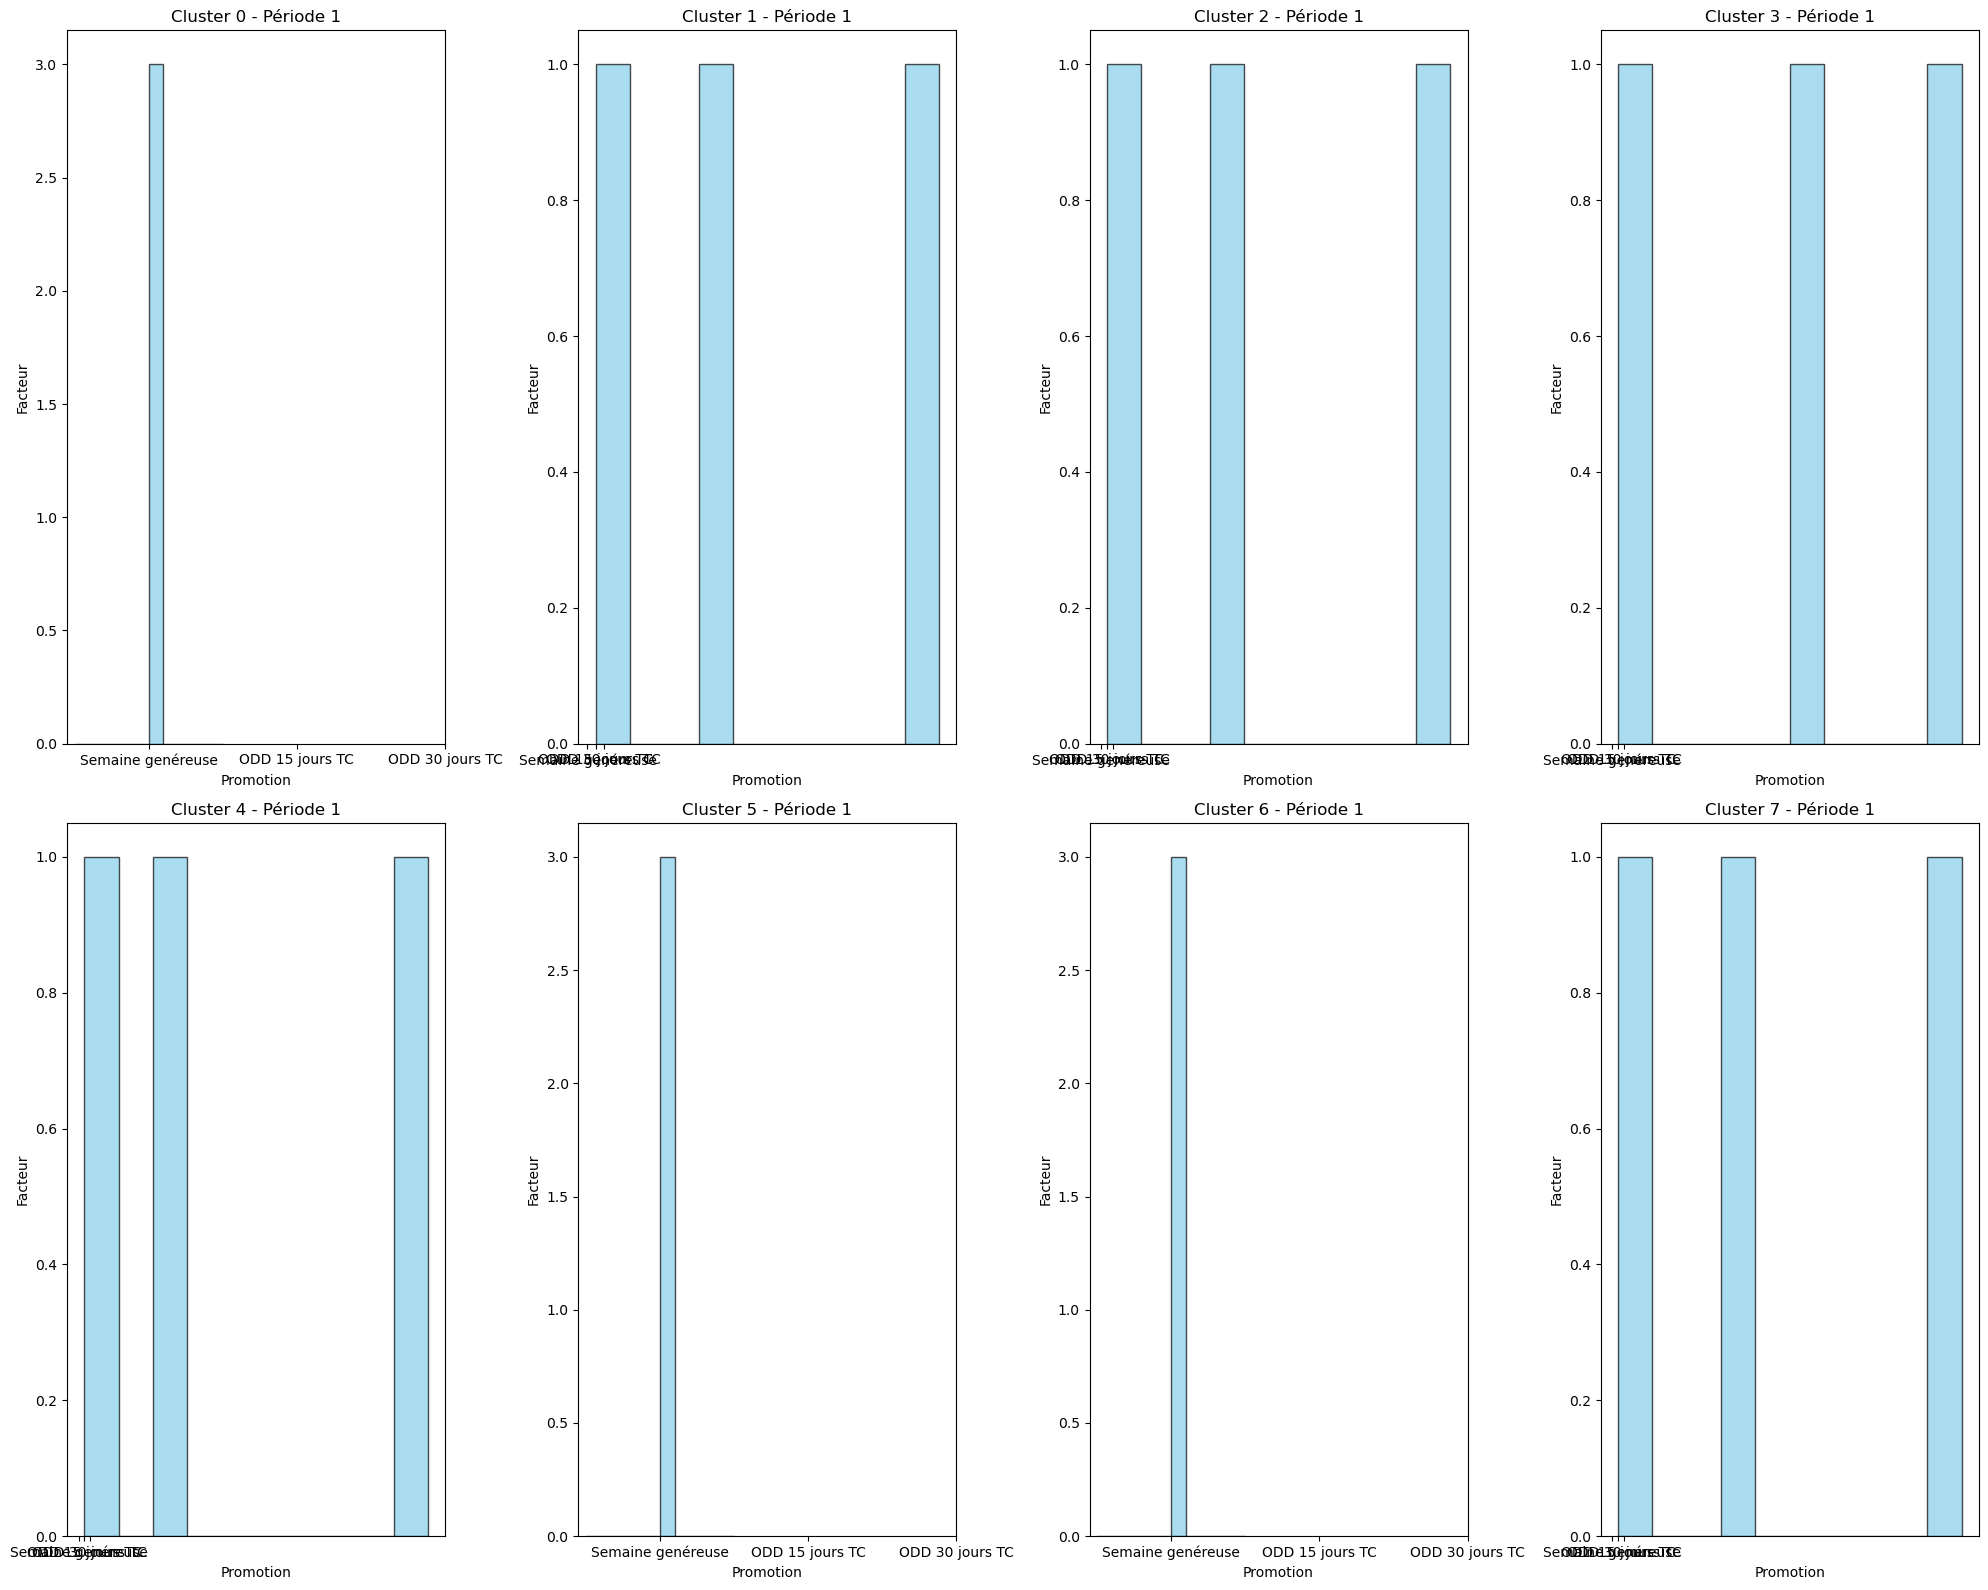

[1.0, 28.406779661016948, 13.208333333333334]
[1.0, 75.34210526315789, 9.632352941176471]
[1.0, 119.83076923076923, 16.372881355932204]
[1.0, 123.25, 11.420289855072463]
[1.0, 91.27272727272727, 21.483333333333334]
[1.0, 8.978260869565217, 2.0526315789473686]
[0.0, 0.0, 0.0]
[1.0, 124.03937007874016, 8.261538461538462]


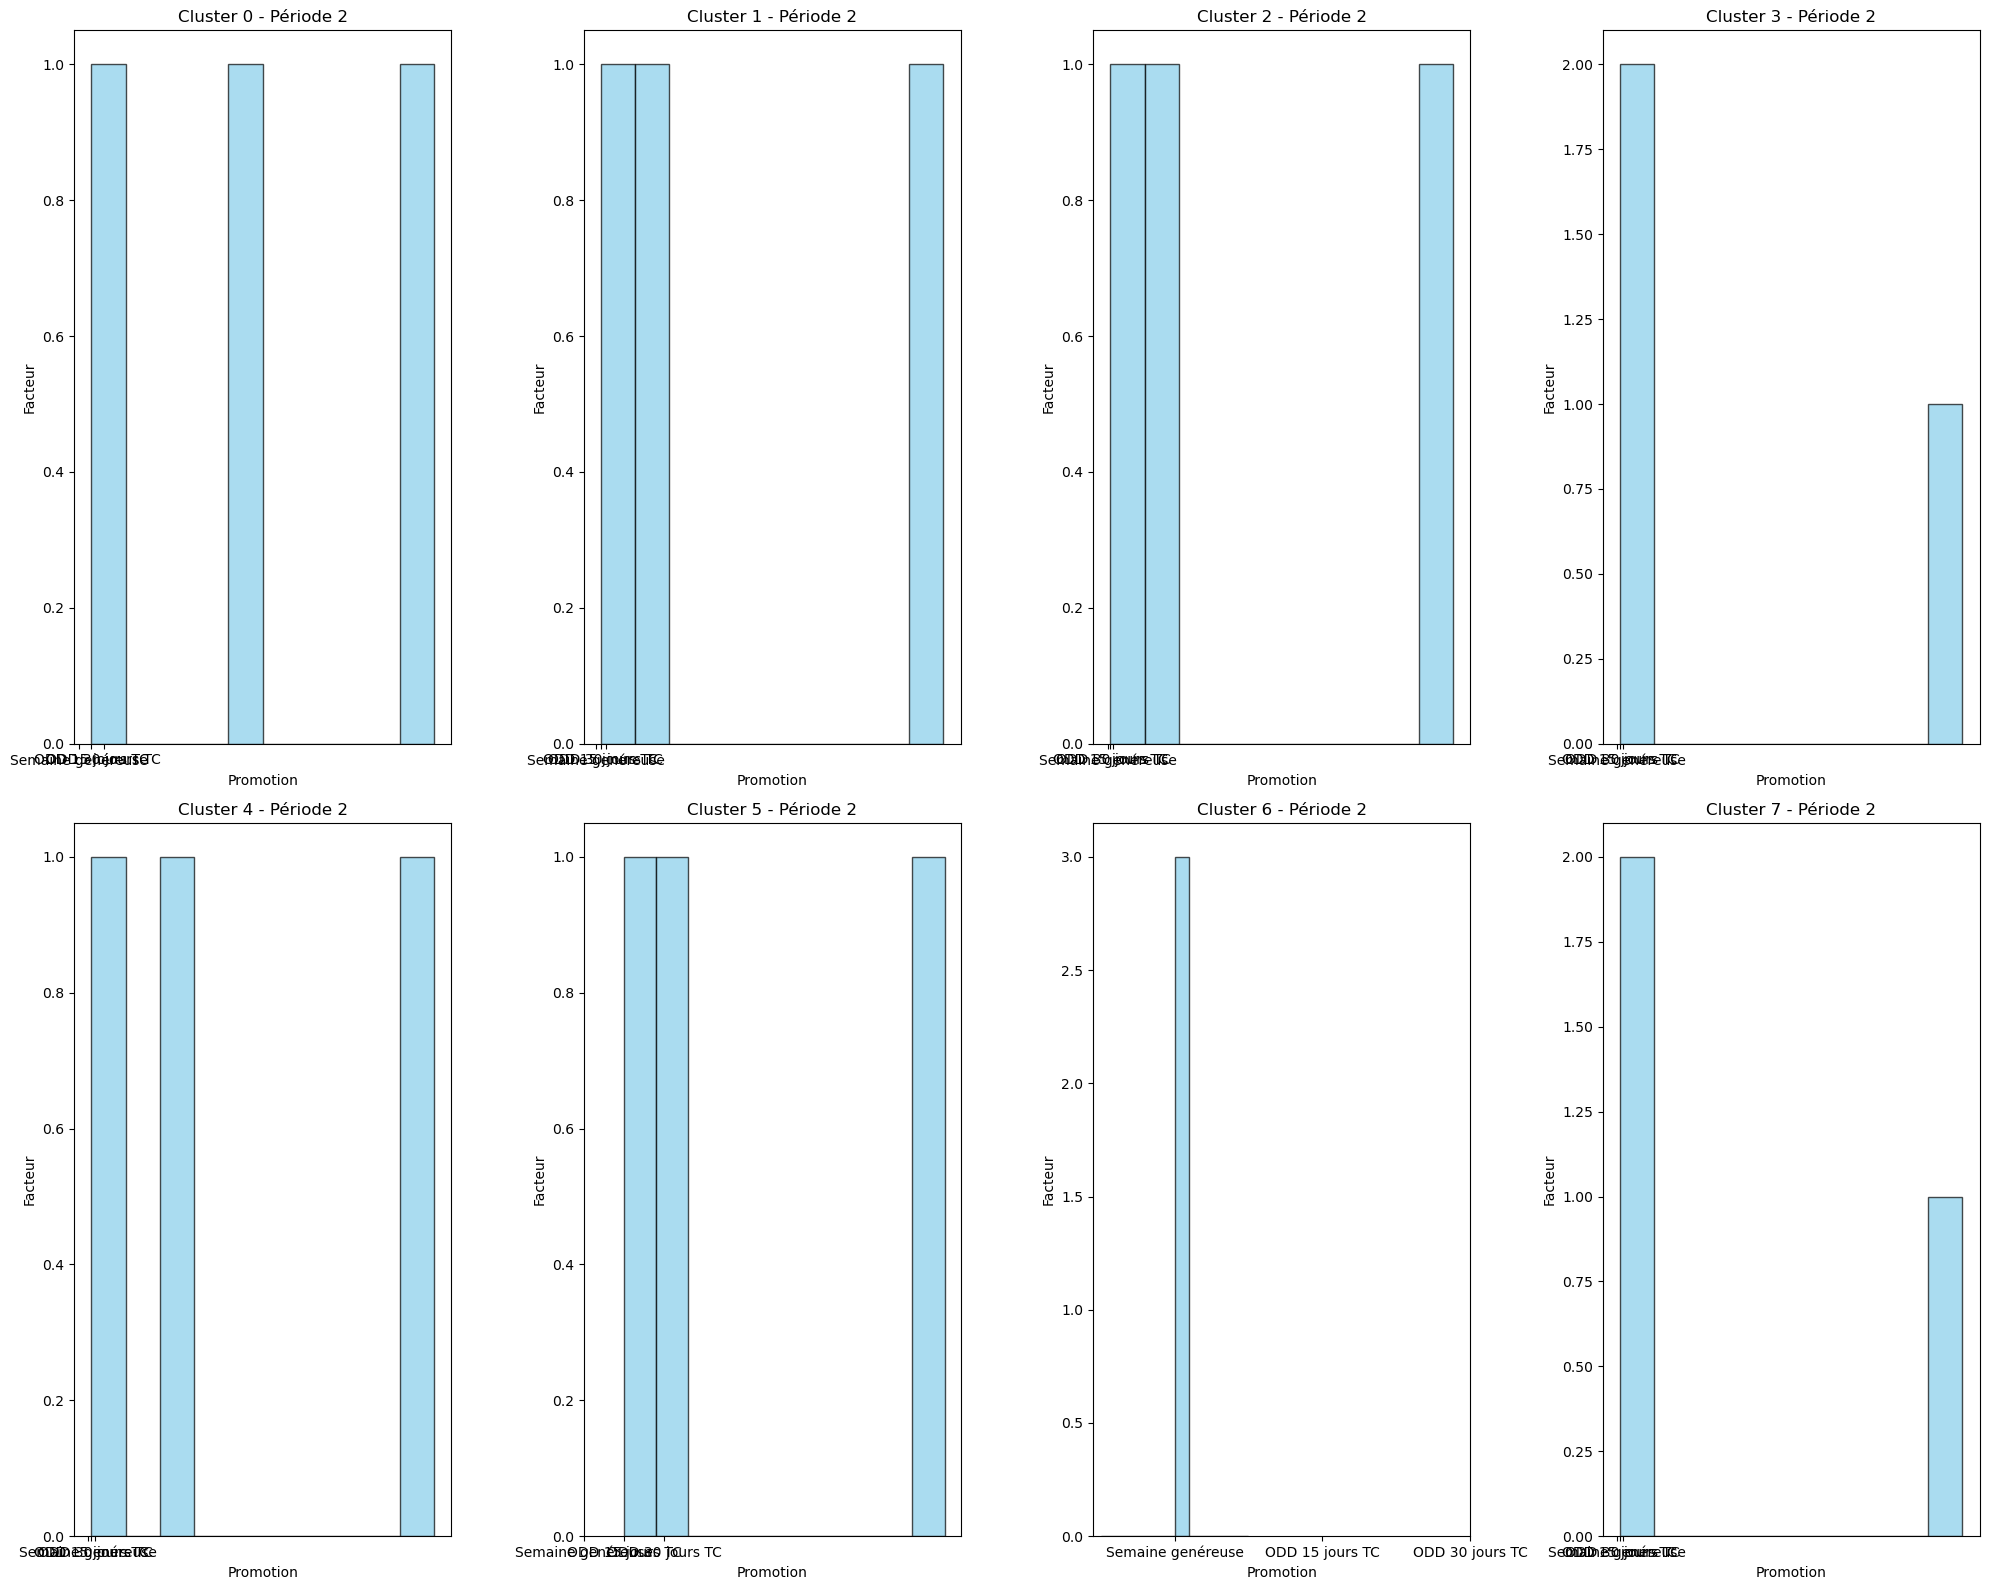

[1.0, 35.162962962962965, 5.082191780821918]
[1.0, 36.333333333333336, 9.185185185185185]
[1.0, 85.41463414634147, 18.472972972972972]
[1.0, 100.62337662337663, 19.736263736263737]
[1.0, 28.894736842105264, 9.717948717948717]
[1.0, 21.04964539007092, 3.090909090909091]
[0.0, 0.0, 0.0]
[1.0, 94.81065088757397, 15.03448275862069]


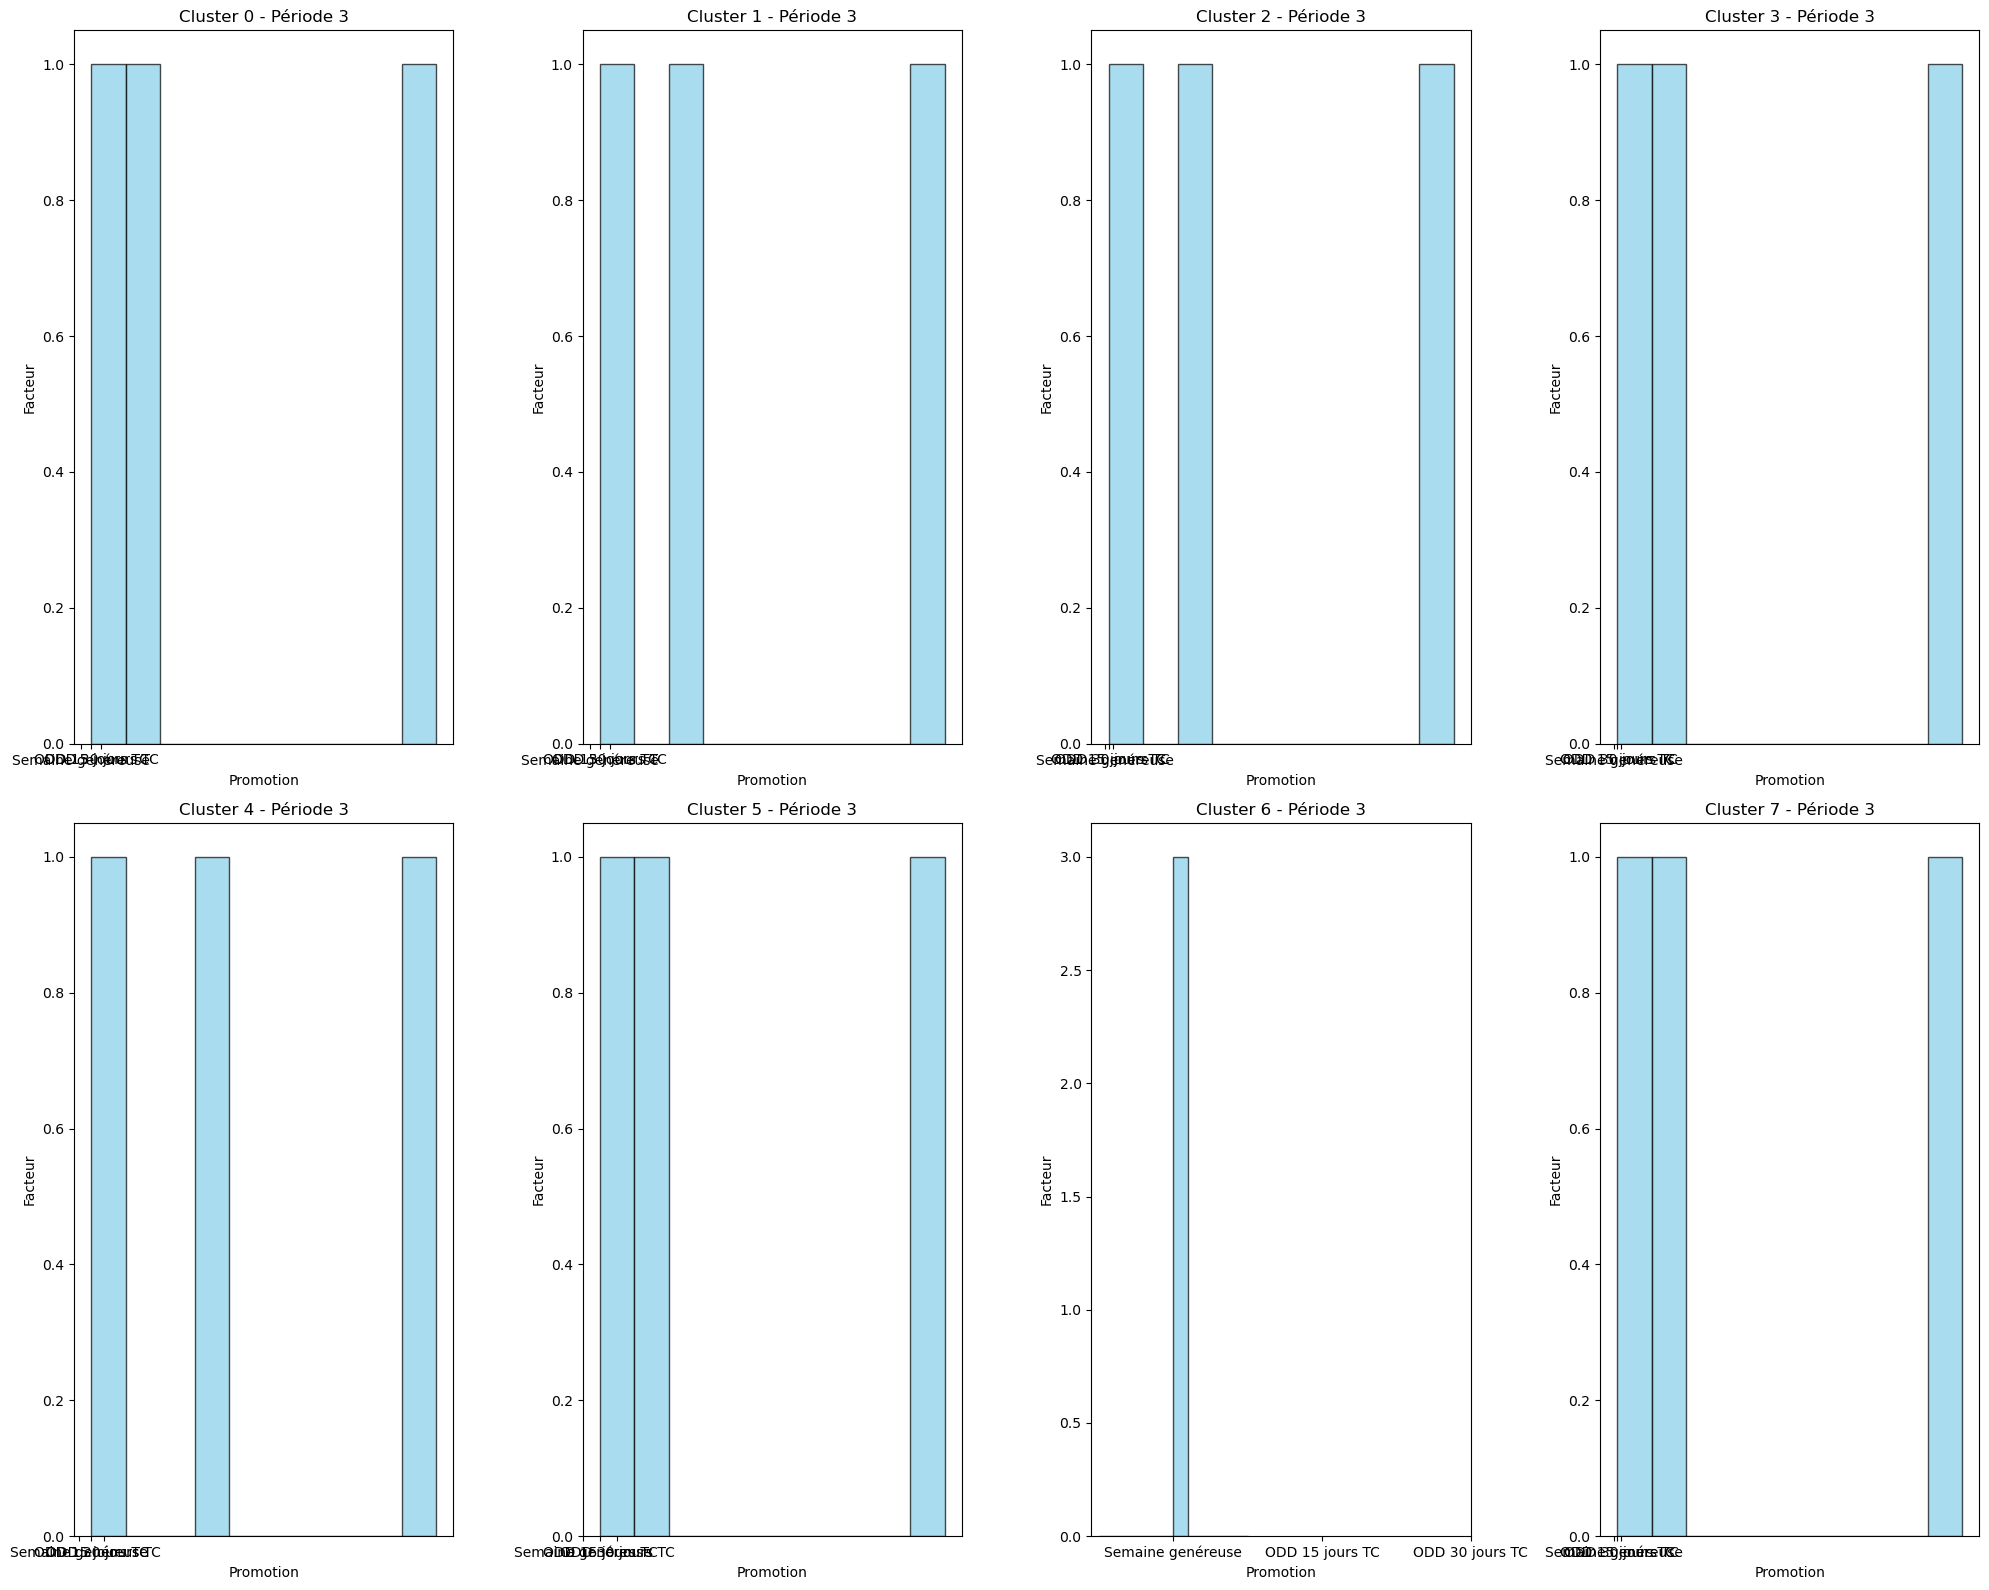

[1.0, 88.1842105263158, 4.925925925925926]
[1.0, 34.78846153846154, 5.87719298245614]
[1.0, 171.19811320754718, 15.381818181818181]
[1.0, 128.3925925925926, 16.31645569620253]
[1.0, 51.97560975609756, 4.211538461538462]
[1.0, 70.17241379310344, 4.423728813559322]
[1.0, 37.76470588235294, 1.3636363636363635]
[1.0, 96.95205479452055, 13.346666666666666]


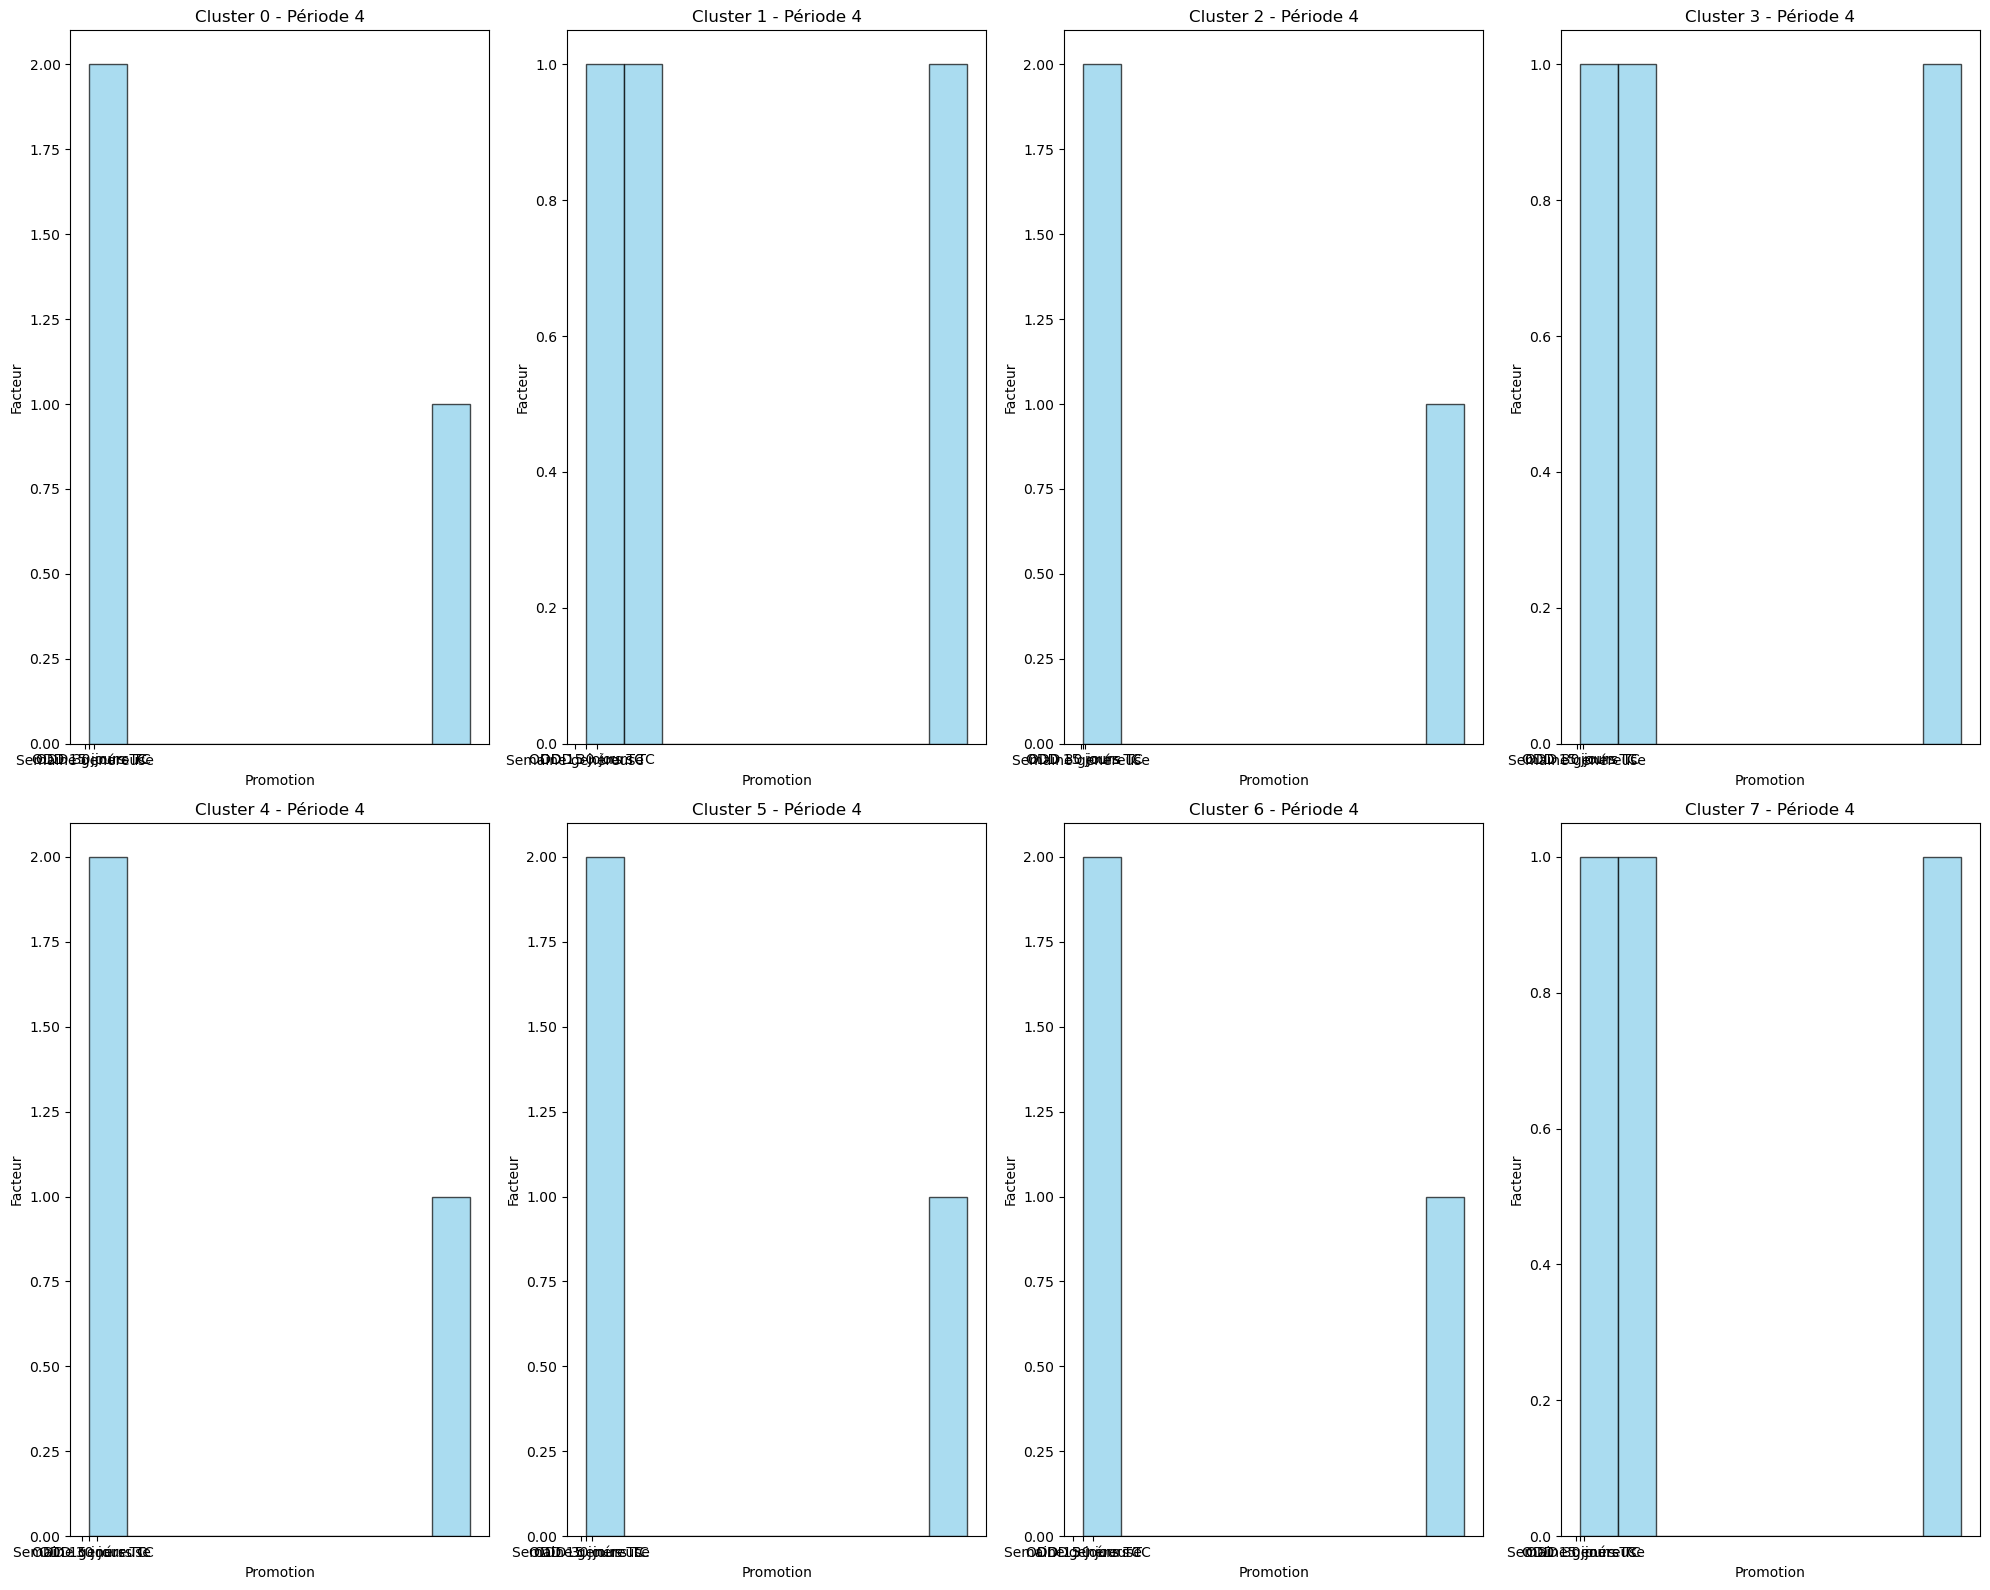

[1.0, 65.23448275862069, 46.970588235294116]
[1.0, 19.093333333333334, 18.790697674418606]
[1.0, 126.74846625766871, 60.94871794871795]
[1.0, 128.44, 48.96666666666667]
[1.0, 24.818181818181817, 26.90625]
[1.0, 105.02808988764045, 34.059701492537314]
[1.0, 60.31137724550898, 27.44736842105263]
[1.0, 113.03389830508475, 32.640449438202246]


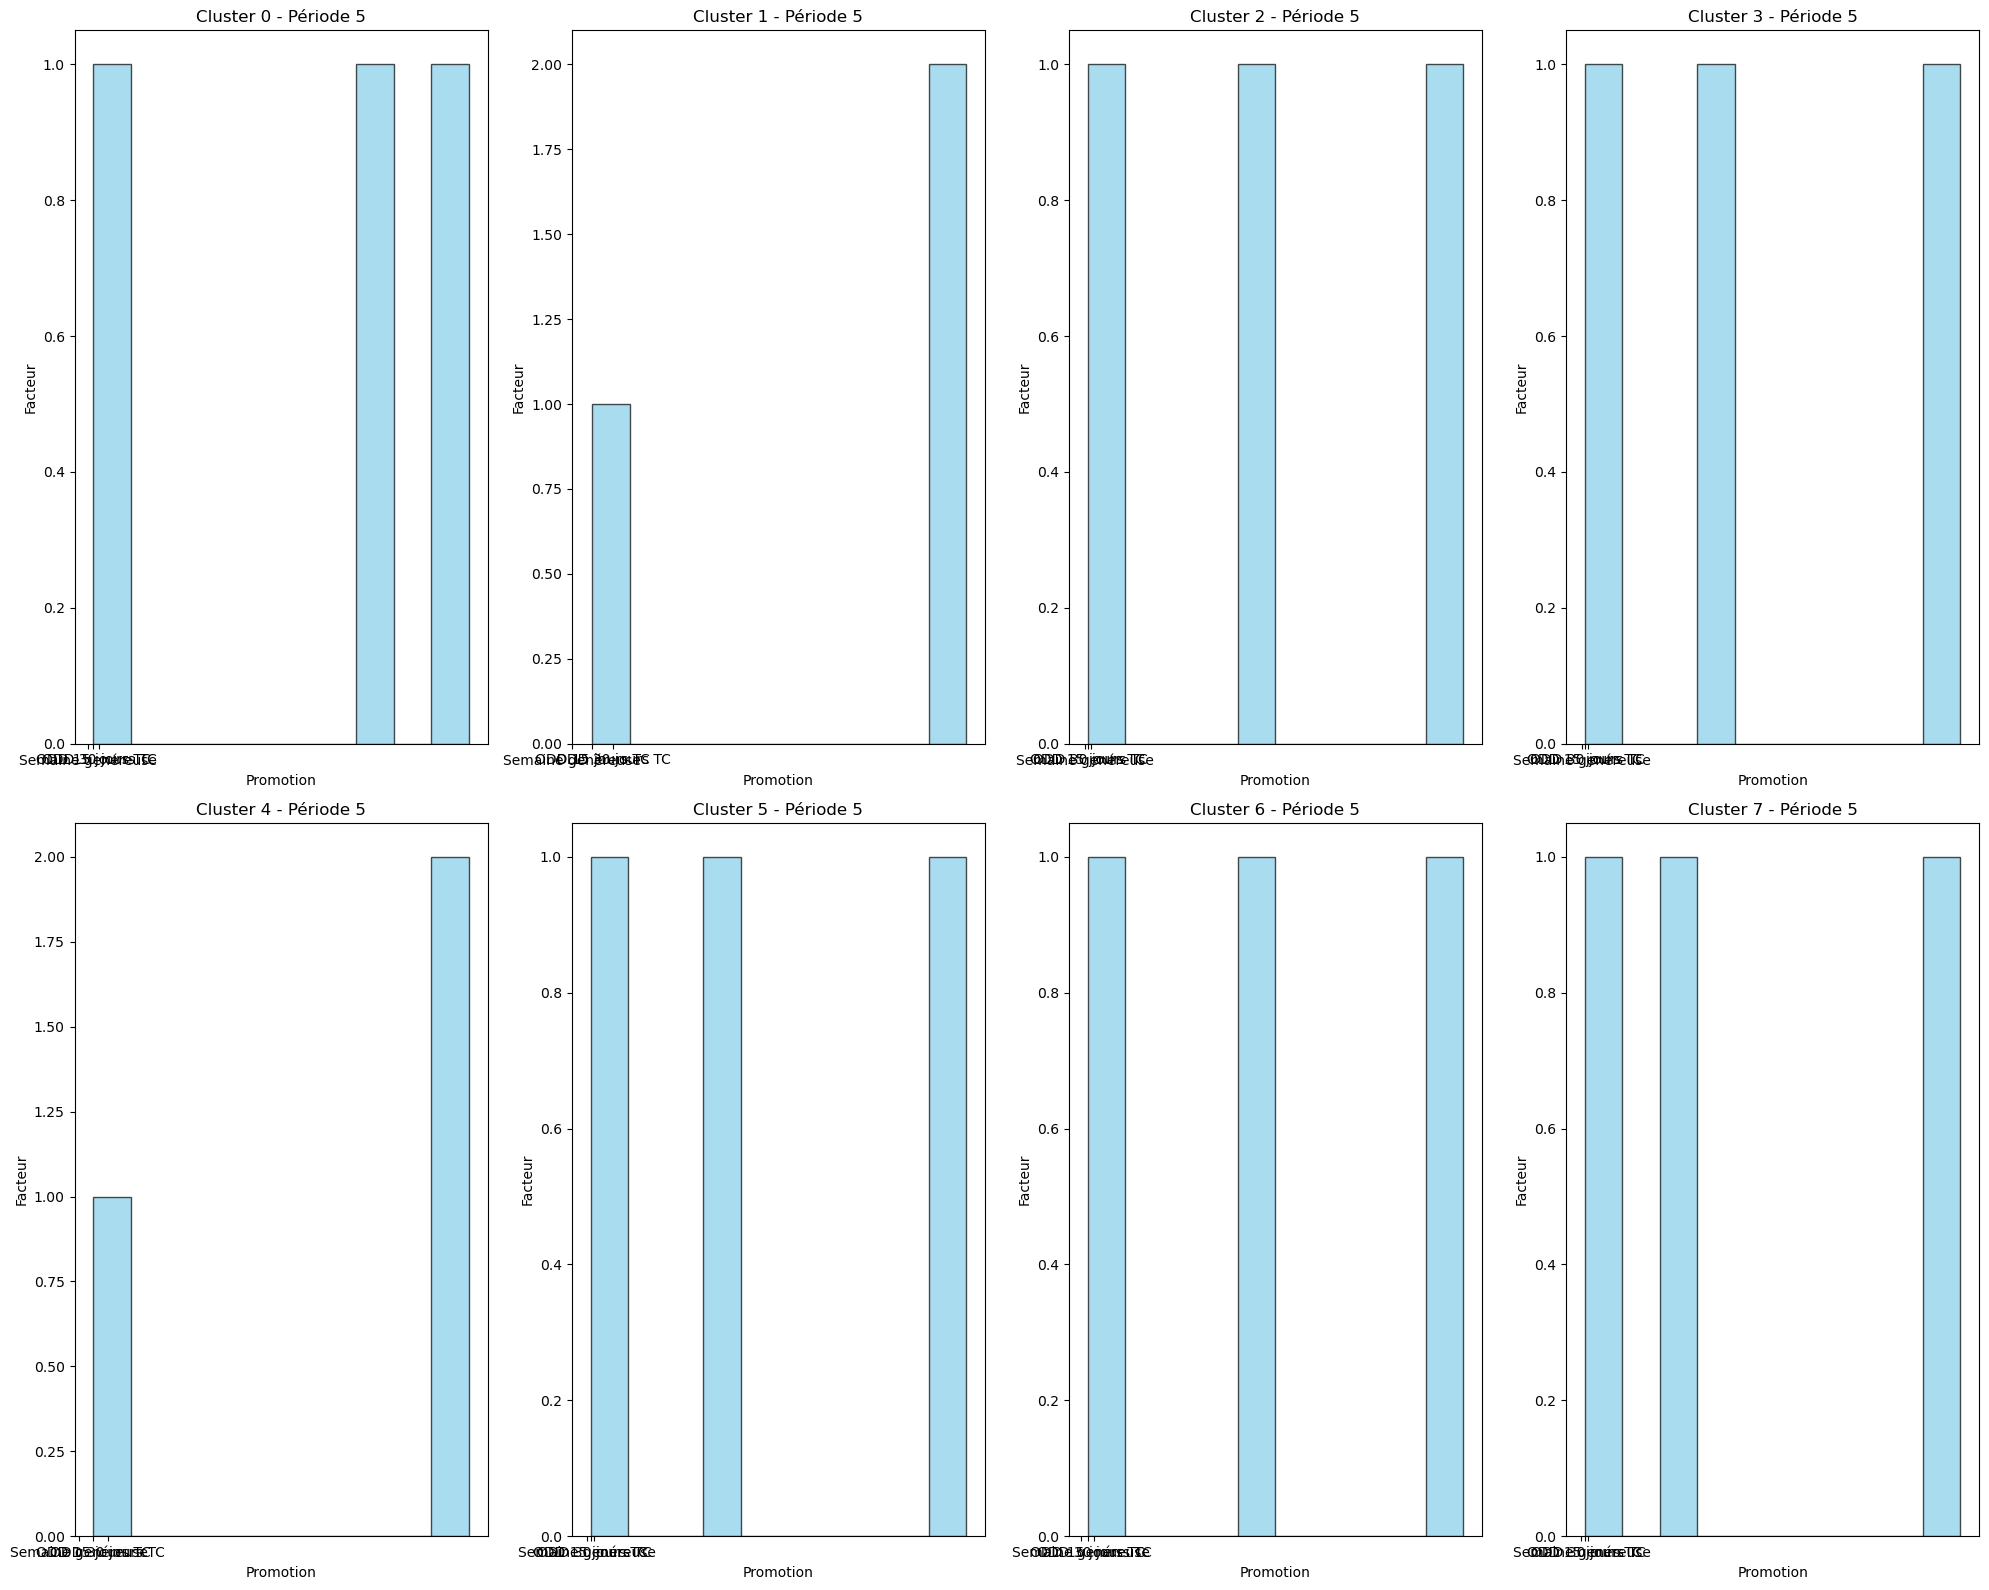

[1.0, 45.364583333333336, 1.0]
[1.0, 12.03061224489796, 1.4375]
[1.0, 82.41441441441441, 1.25]
[1.0, 88.05511811023622, 3.41025641025641]
[1.0, 22.22077922077922, 1.0]
[1.0, 72.21969696969697, 1.9]
[1.0, 60.688, 1.0]
[1.0, 85.2248062015504, 2.4791666666666665]


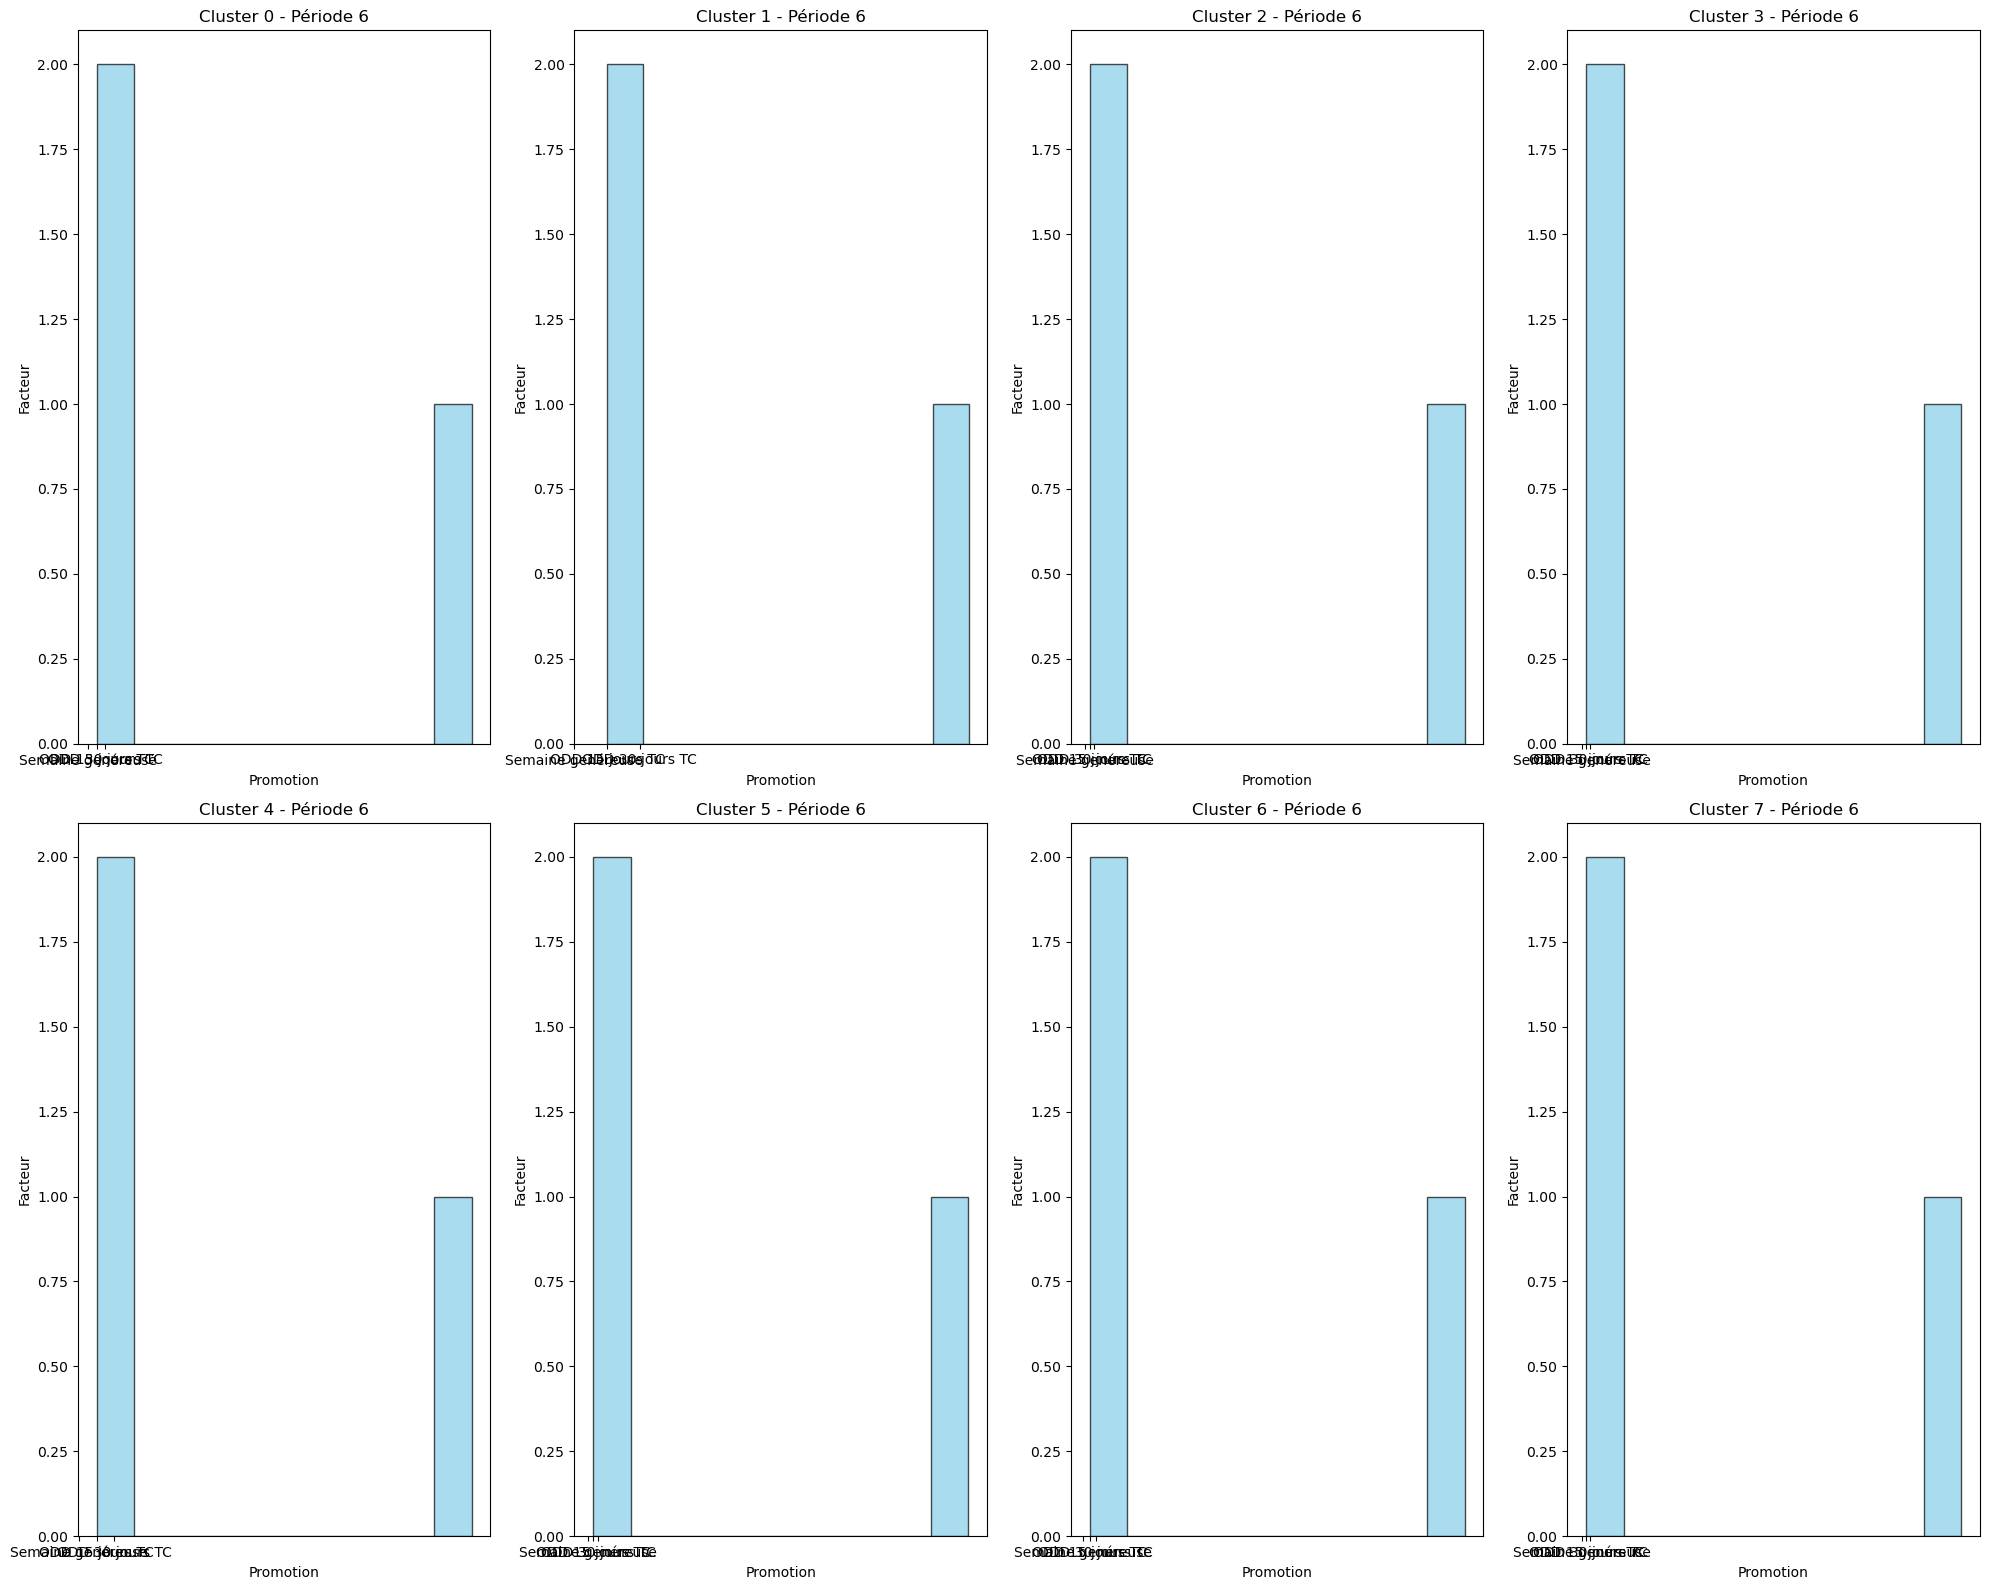

In [ ]:

liste_promotions = ['Semaine genéreuse', 'ODD 15 jours TC', 'ODD 30 jours TC']

# Créer une nouvelle figure à l'extérieur de la boucle
#fig = plt.figure(figsize=(20, 16))

# Boucler à travers chaque ligne du DataFrame
for i in range(1, 7, 1):
    fig = plt.figure(figsize=(20, 16))
    for index, row in dataset_cluster_explanations_shortened.iterrows():
        # Créer une liste de valeurs des colonnes 'Facteur d'abonnement pour {promo} sur la période {i}'
        valeurs_promotions = [row[f"Facteur d'abonnement pour {promo} sur la période {i}"] for promo in liste_promotions]
        print(valeurs_promotions)
        # Calculer l'index du sous-graphique dans une grille de 6x8
        subplot_index = index+1
        
        # Ajouter un sous-plot à la figure pour l'histogramme
        ax = fig.add_subplot(2, 4, subplot_index)
        ax.hist(valeurs_promotions, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
        ax.set_title(f'Cluster {int(row["Cluster"])} - Période {i}')
        ax.set_xlabel('Promotion')
        ax.set_ylabel('Facteur')

        # Définir les étiquettes sur l'axe des y avec les noms des promotions
        ax.set_xticks(range(len(liste_promotions)))
        ax.set_xticklabels(liste_promotions)
        
    # Ajuster la disposition pour éviter les chevauchements
    fig.tight_layout()

    # Enregistrer la figure dans un fichier
    nom_fichier_temporaire = f"histogrammes_clusters_Period_{i}.png"
    plt.savefig(nom_fichier_temporaire)

    # Enregistrer le fichier temporaire sur S3
    with fs.open(BUCKET + nom_fichier_temporaire, mode='wb') as file_out:
        with open(nom_fichier_temporaire, 'rb') as temp_file:
            file_out.write(temp_file.read())

    # Supprimer le fichier temporaire
    os.remove(nom_fichier_temporaire)

    # Afficher la figure
    plt.show()


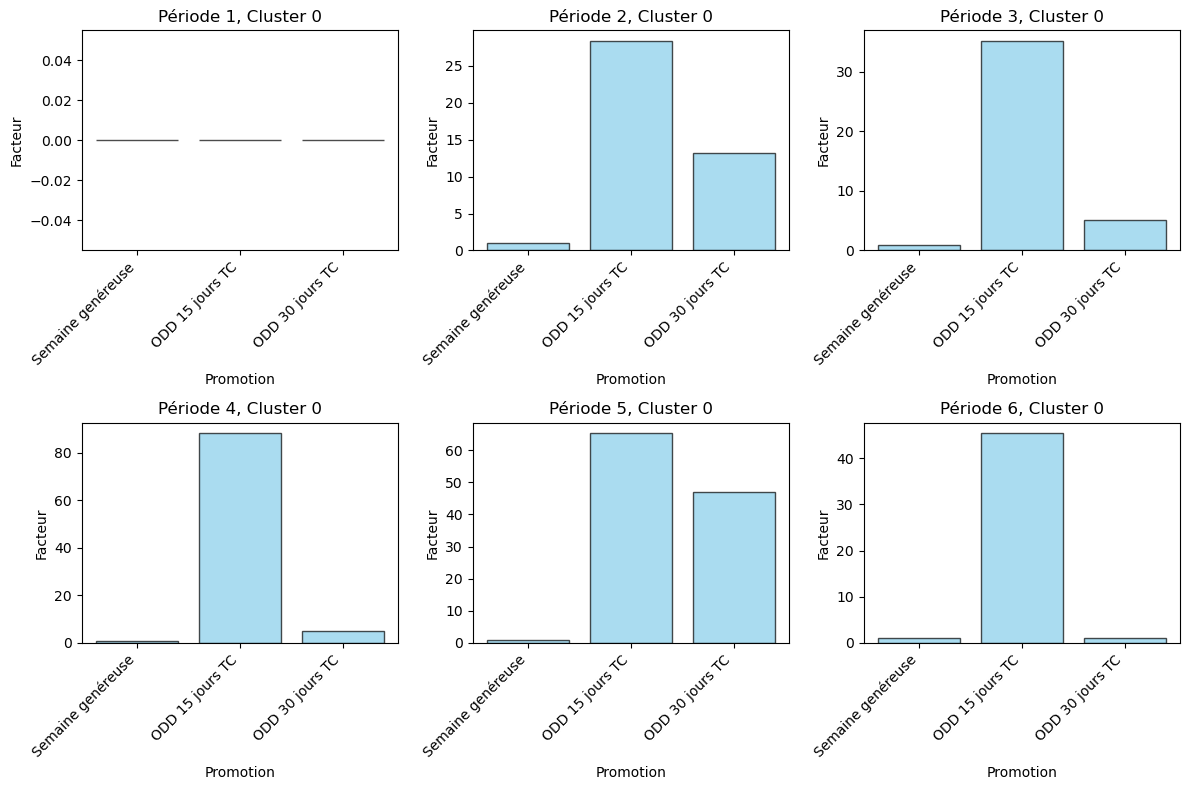

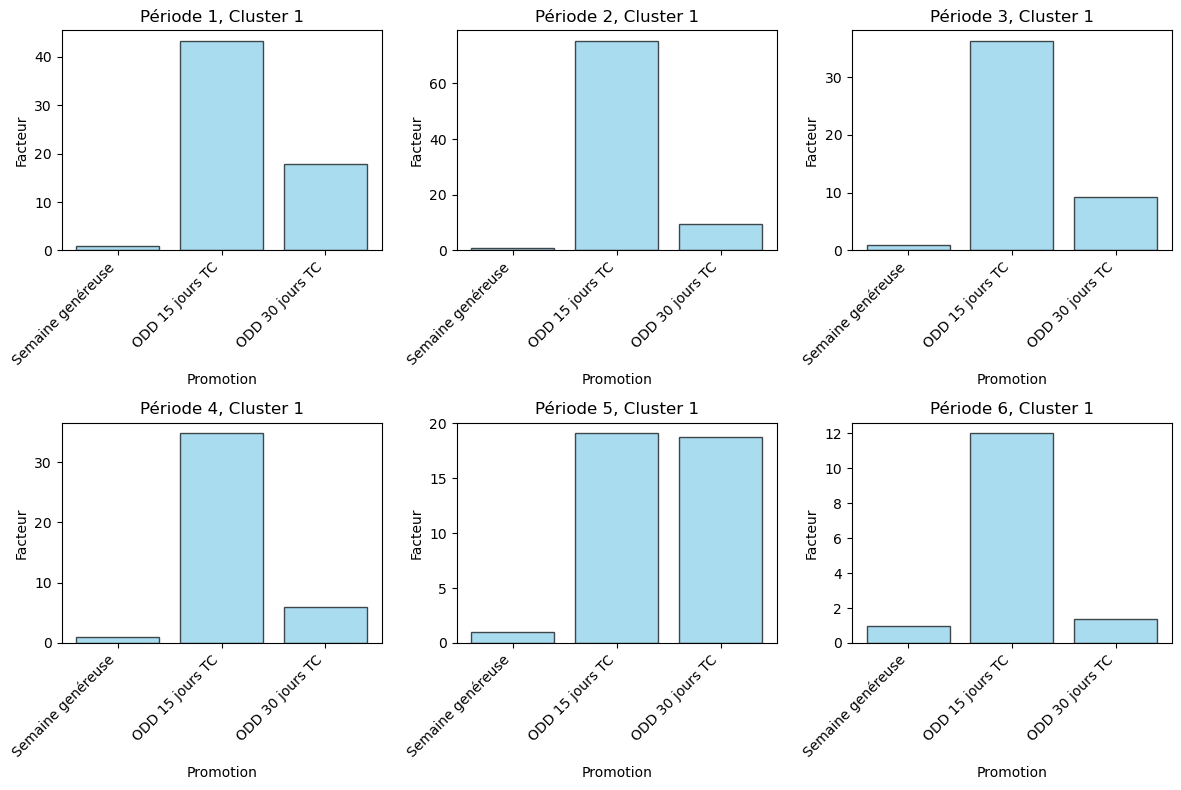

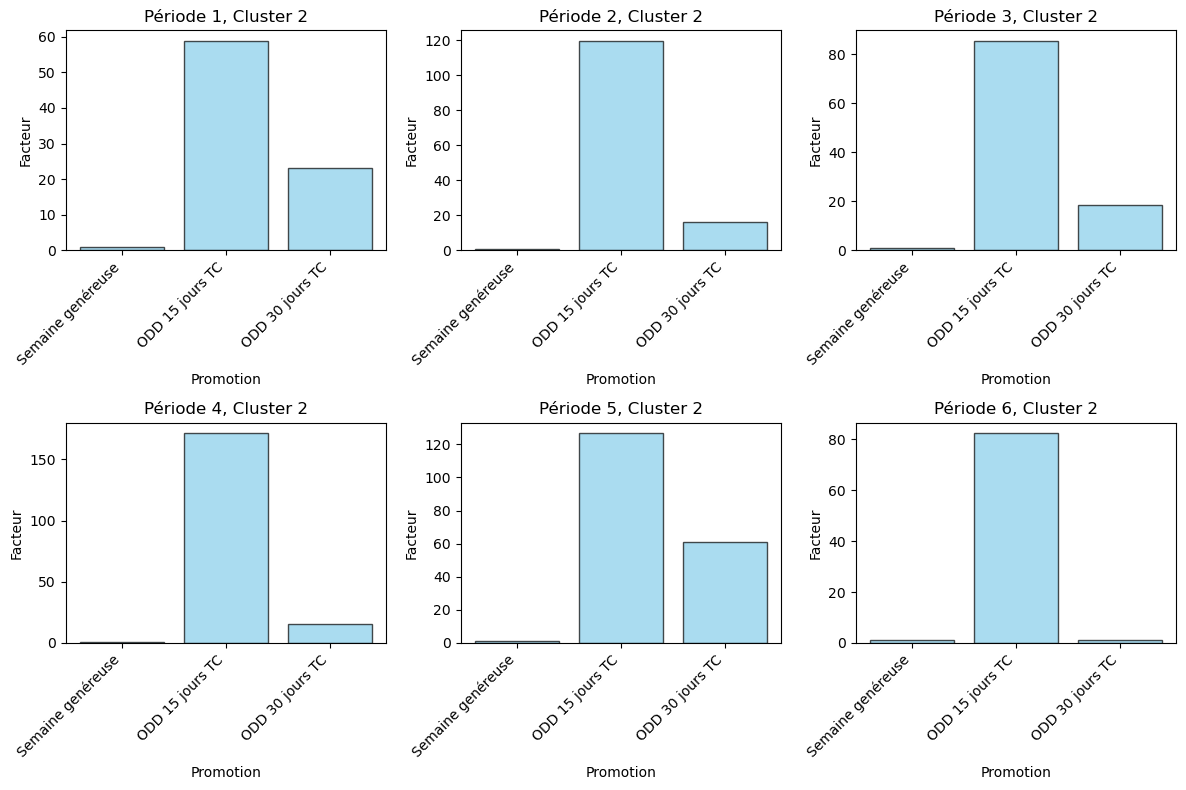

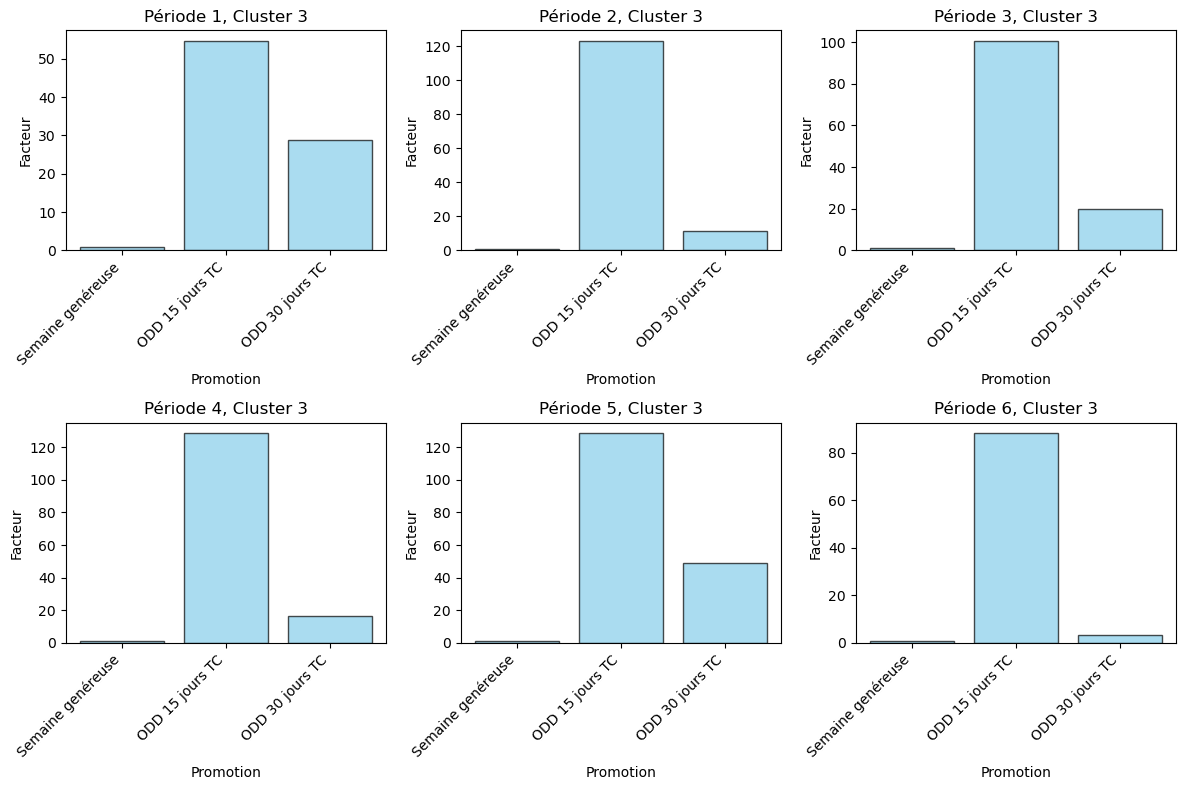

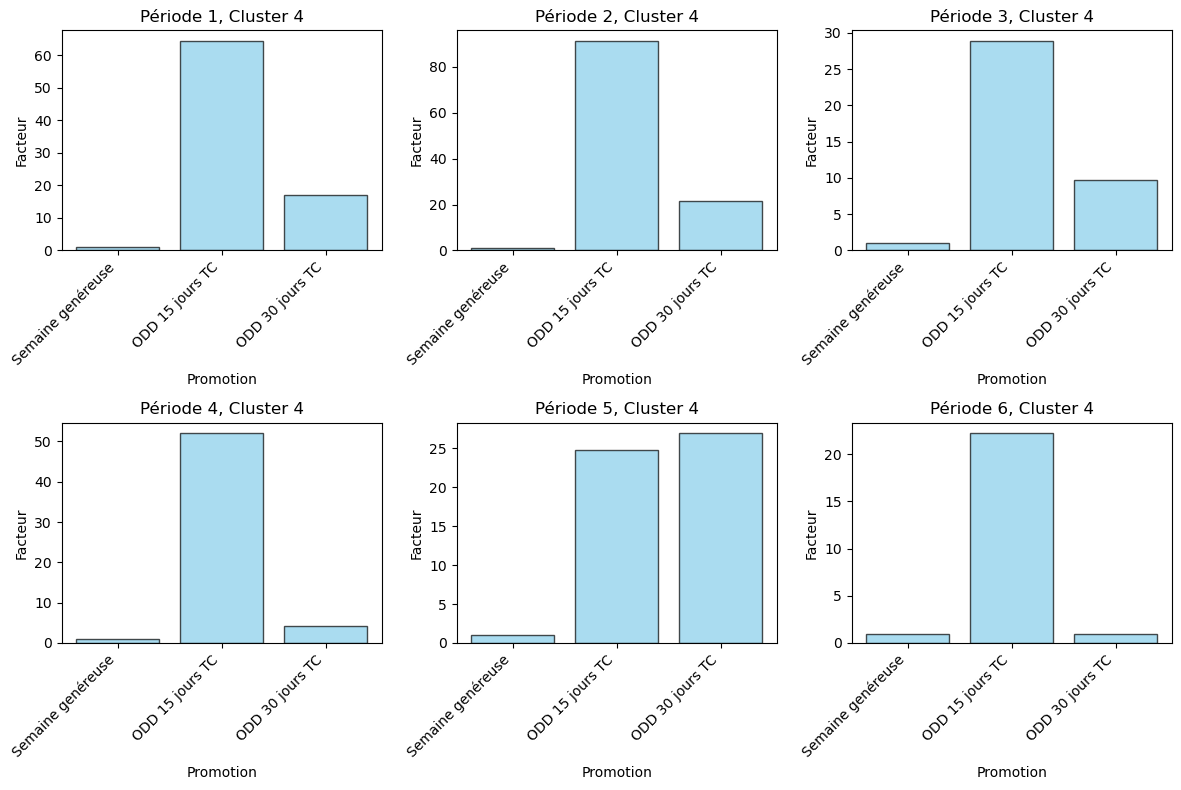

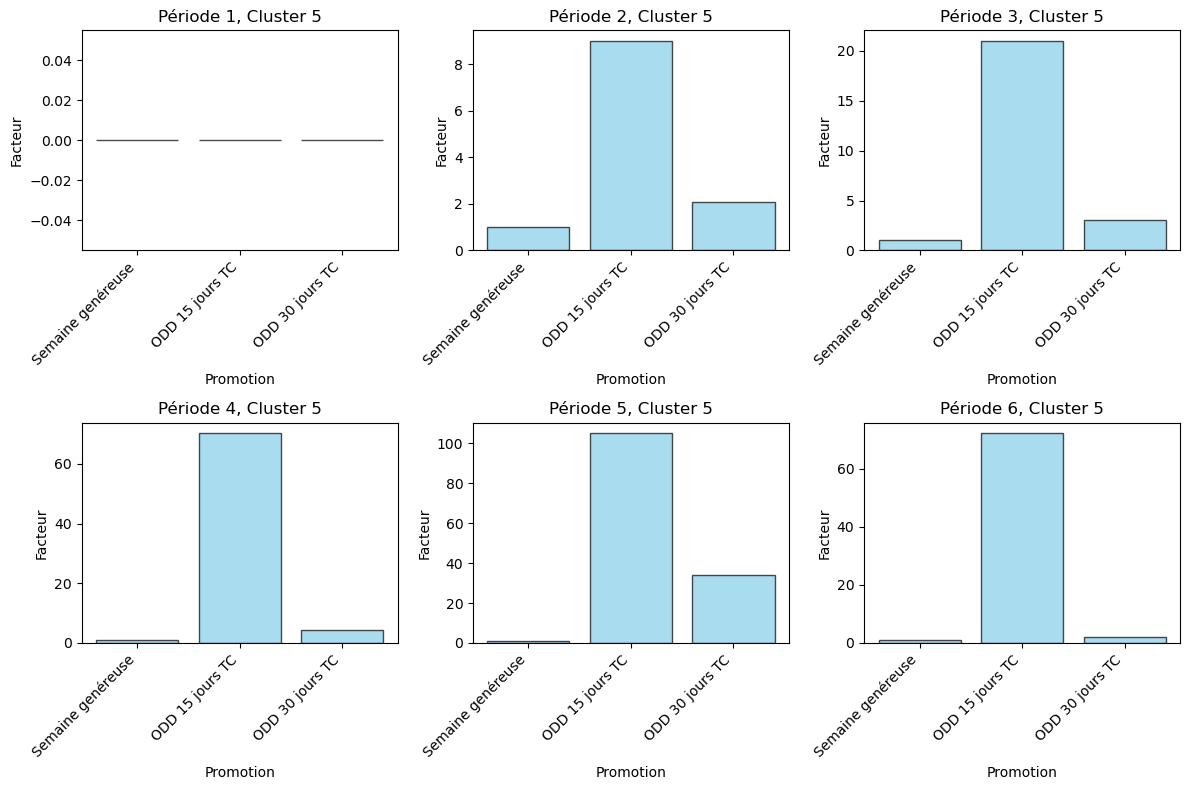

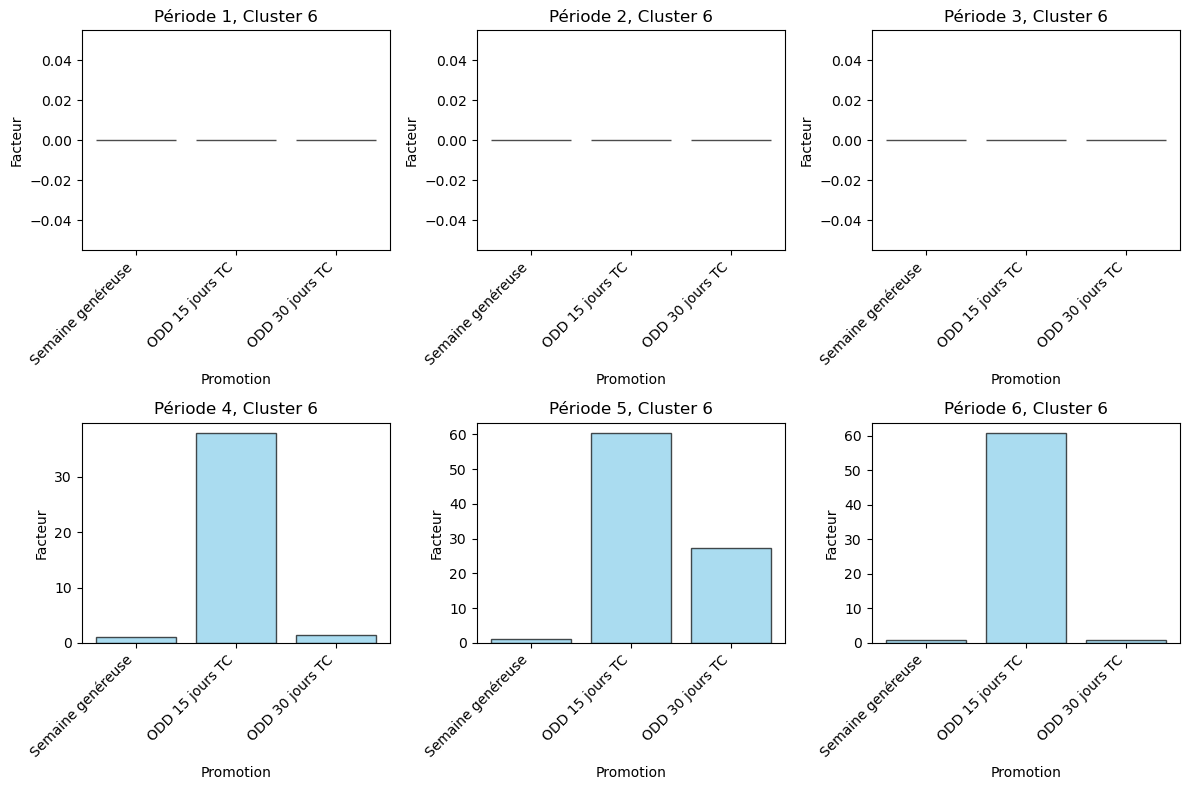

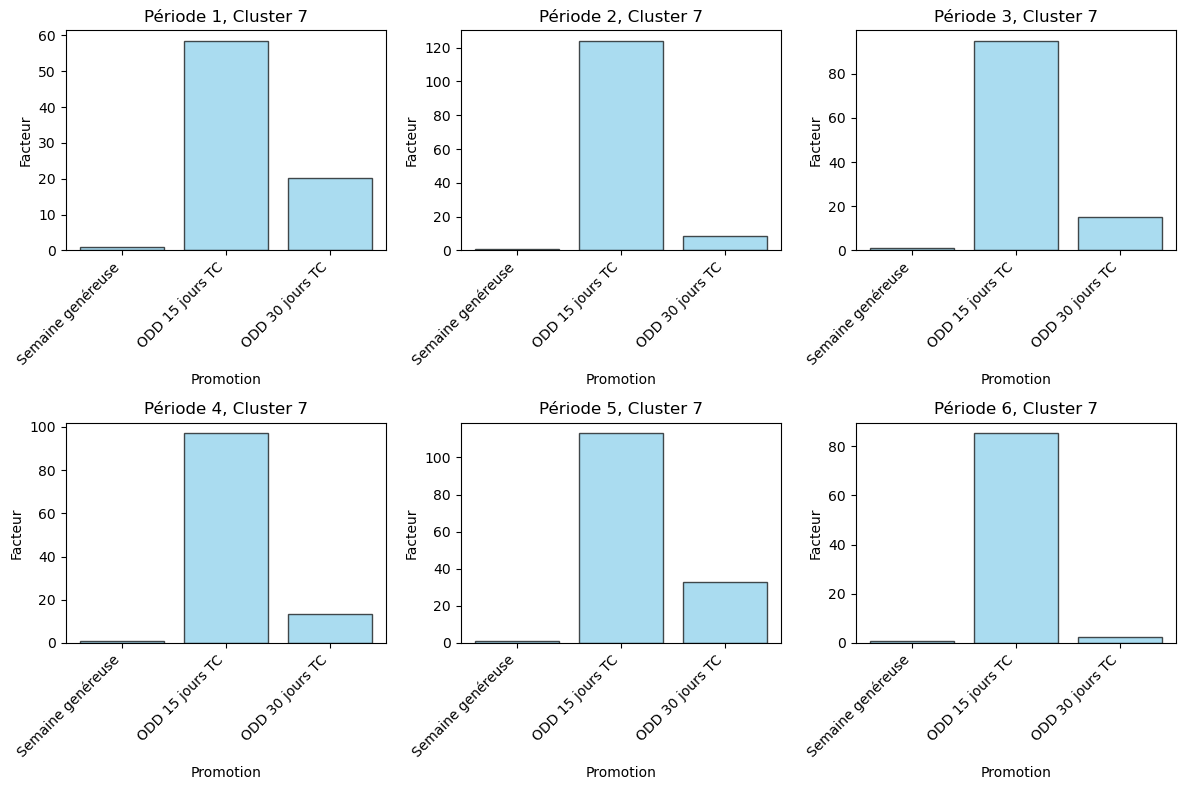

In [22]:
liste_promotions = ['Semaine genéreuse', 'ODD 15 jours TC', 'ODD 30 jours TC']
liste_clusters = list(range(8))

# Boucler à travers chaque cluster
for cluster in liste_clusters:
    # Créer une figure pour ce cluster
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))

    # Boucler à travers chaque période
    for i, ax in enumerate(axs.flatten(), start=1):
        # Récupérer les valeurs des promotions pour ce cluster et cette période
        valeurs_promotions = [dataset_cluster_explanations_shortened.iloc[cluster][f"Facteur d'abonnement pour {promo} sur la période {i}"] for promo in liste_promotions]
        
        # Créer l'histogramme pour ce cluster et cette période
        ax.bar(liste_promotions, valeurs_promotions, color='skyblue', edgecolor='black', alpha=0.7)
        ax.set_title(f'Période {i}, Cluster {cluster}')
        ax.set_xlabel('Promotion')
        ax.set_ylabel('Facteur')

        # Faire pivoter les étiquettes de l'axe x pour une meilleure lisibilité
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Ajuster la disposition pour éviter les chevauchements
    plt.tight_layout()

    # Enregistrer la figure dans un fichier
    nom_fichier_temporaire = f"histogrammes_shortened_cluster_{cluster}.png"
    plt.savefig(nom_fichier_temporaire)

    # Enregistrer le fichier temporaire sur S3
    with fs.open(BUCKET + 'Batons_shortened/' + nom_fichier_temporaire, mode='wb') as file_out:
        with open(nom_fichier_temporaire, 'rb') as temp_file:
            file_out.write(temp_file.read())

    # Supprimer le fichier temporaire
    os.remove(nom_fichier_temporaire)

    # Afficher la figure
    plt.show()


['ODD 30 jours TC', 'ODD 21 jours TC', 'ODD 15 jours TC', 'Semaine genéreuse', 'PAS_ODD', 'ODD 7 jours autre que SG', 'ODD 15 jours EV+', 'ODD 30 jours EV+', 'Autres']


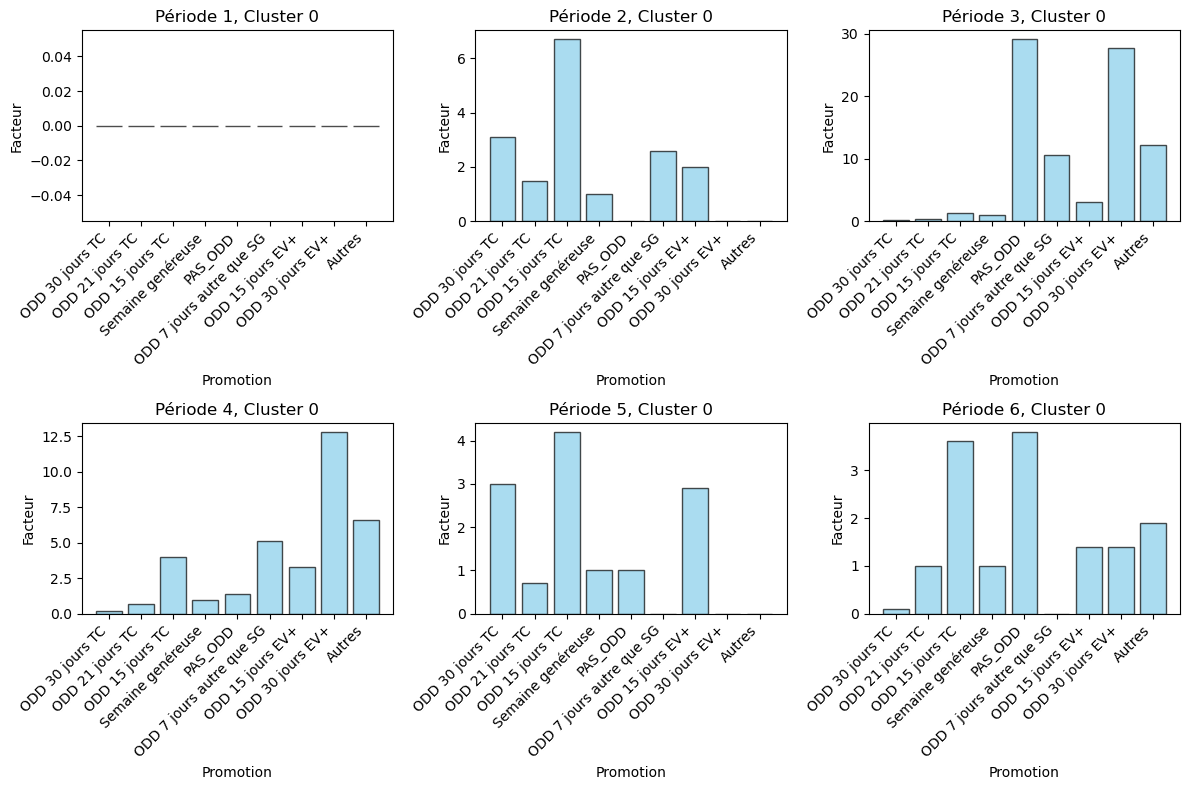

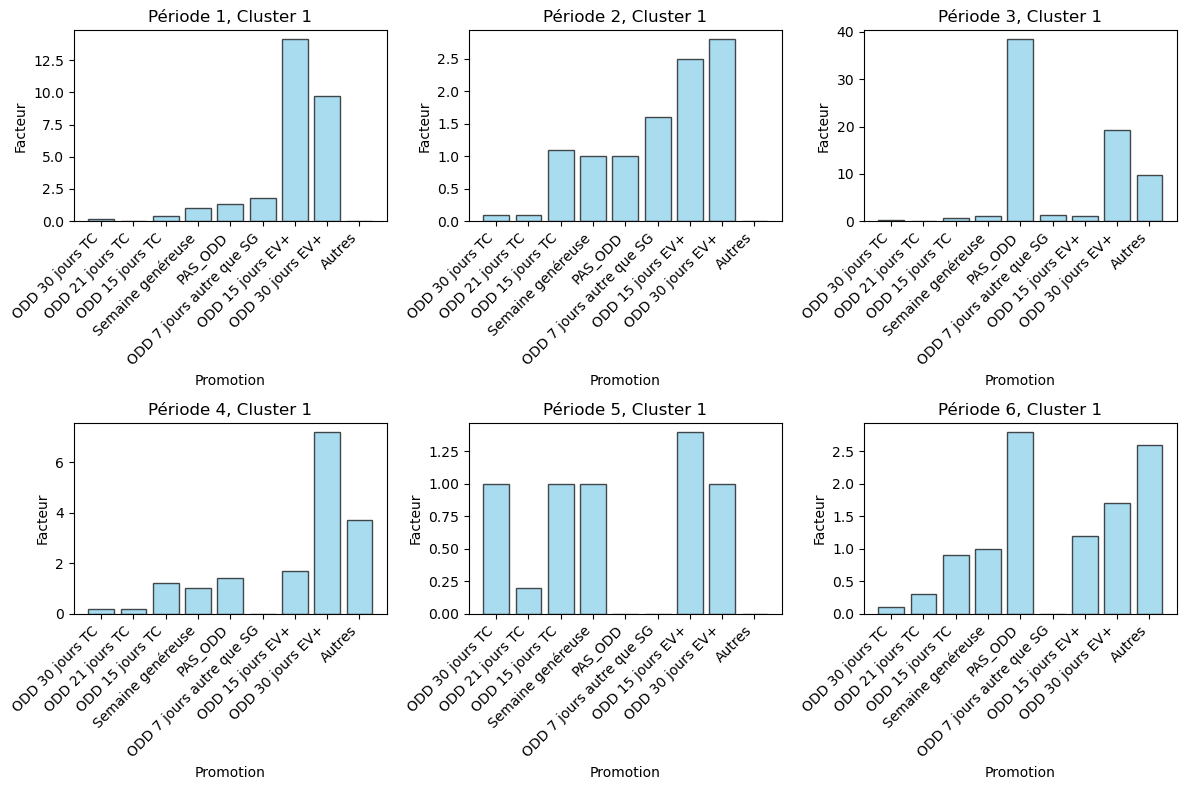

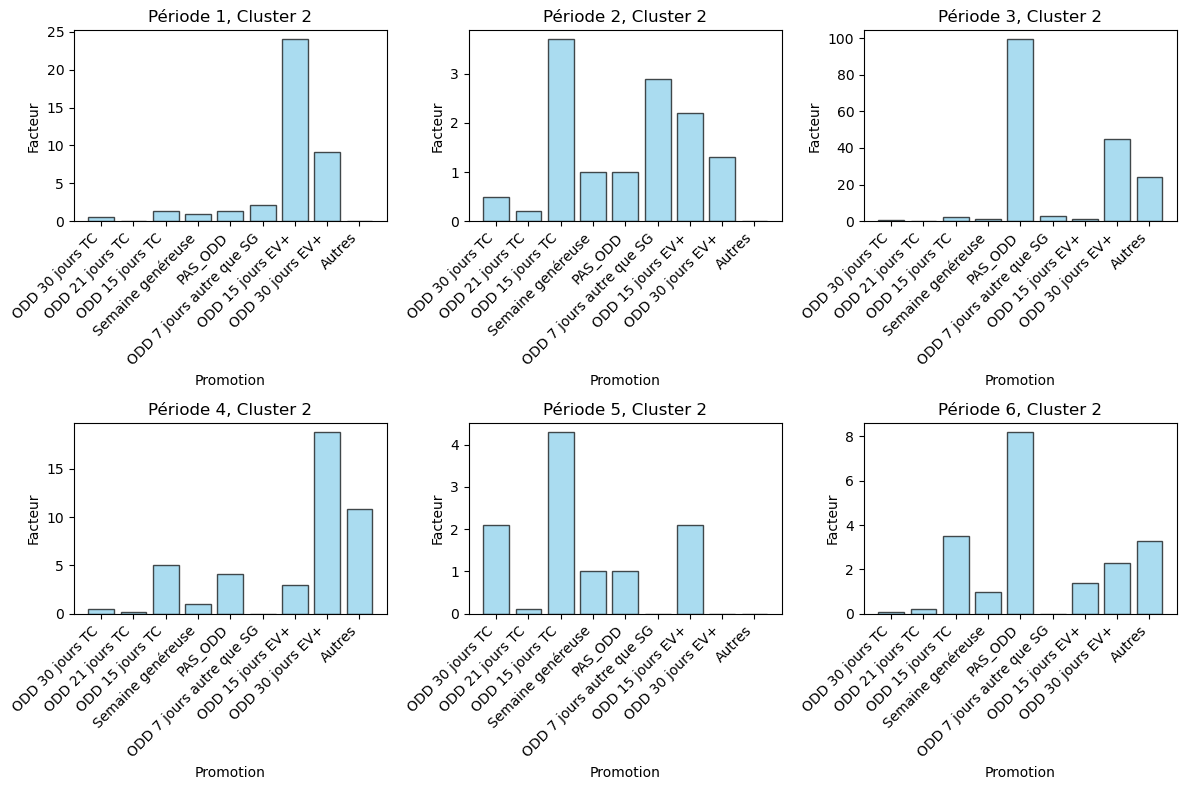

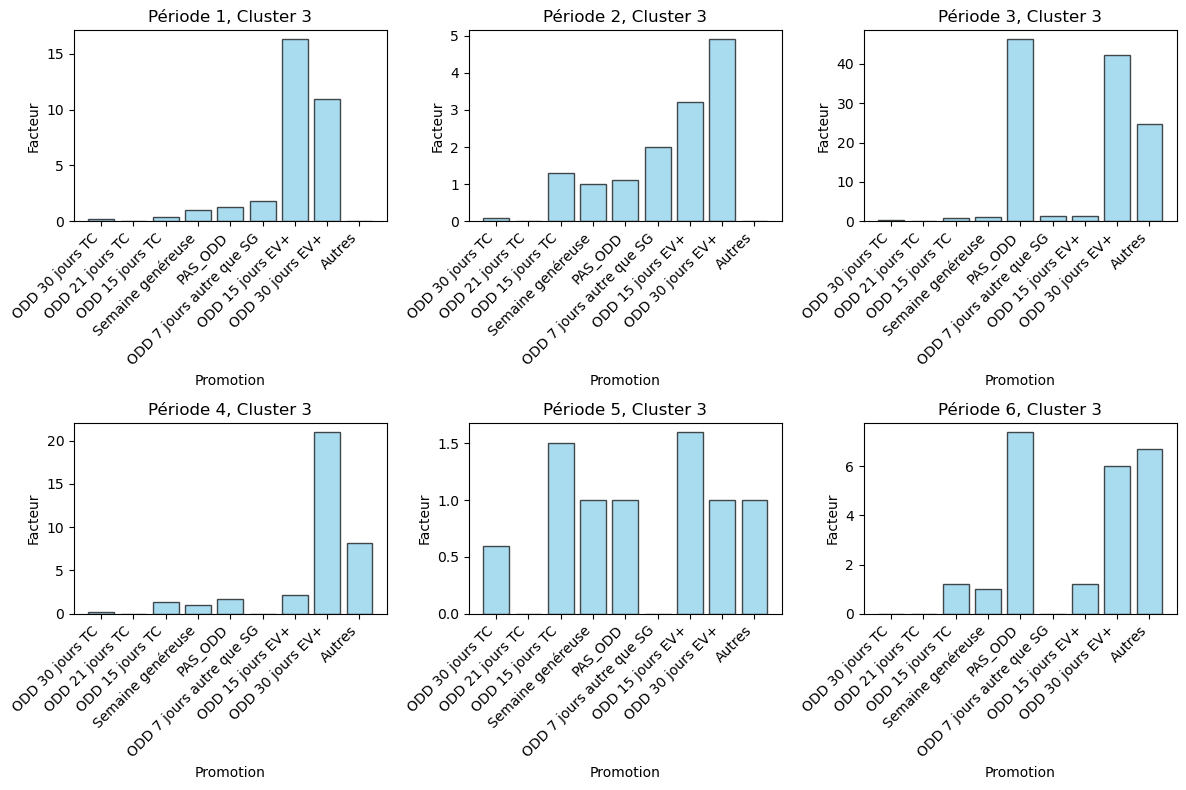

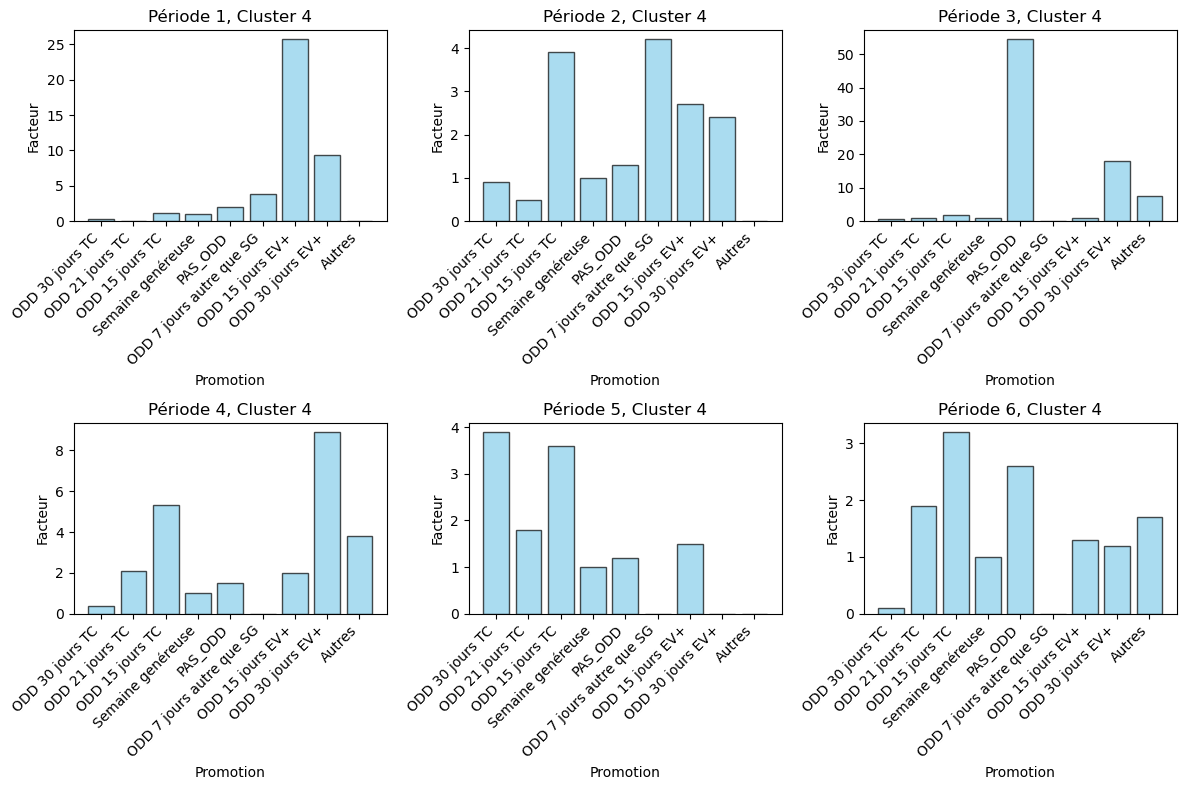

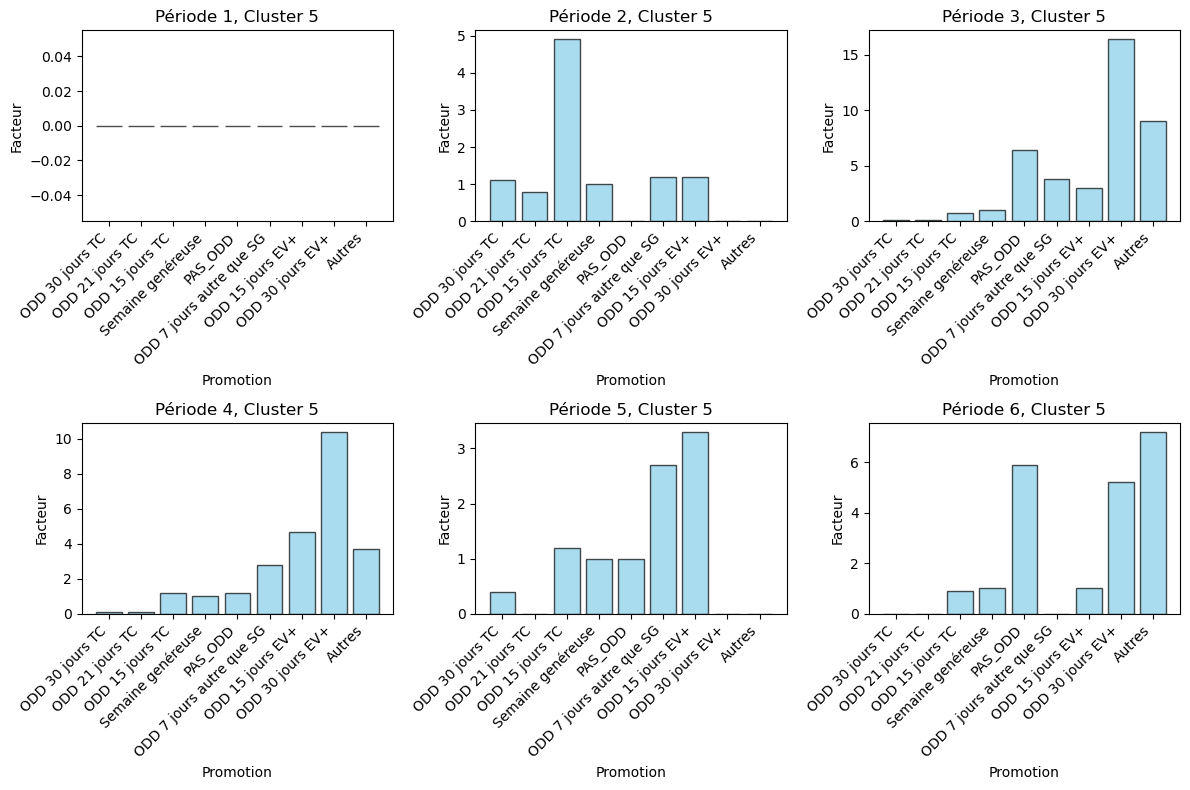

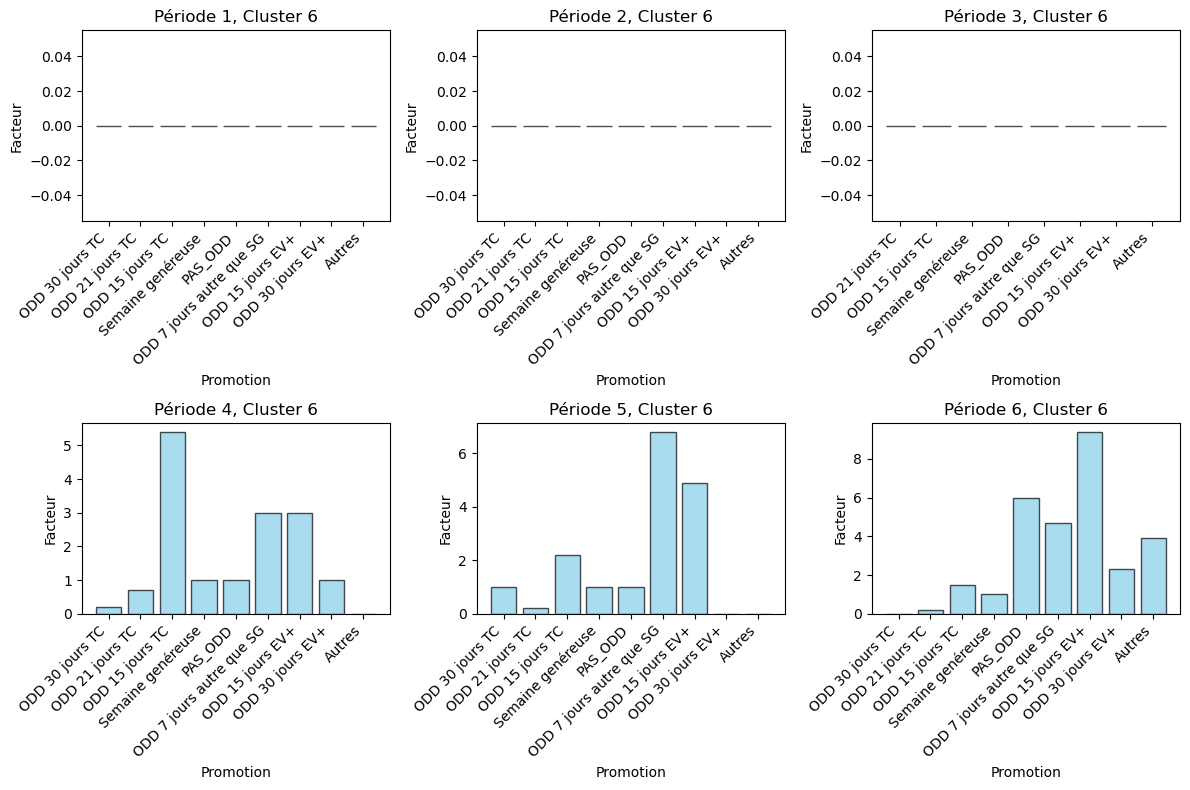

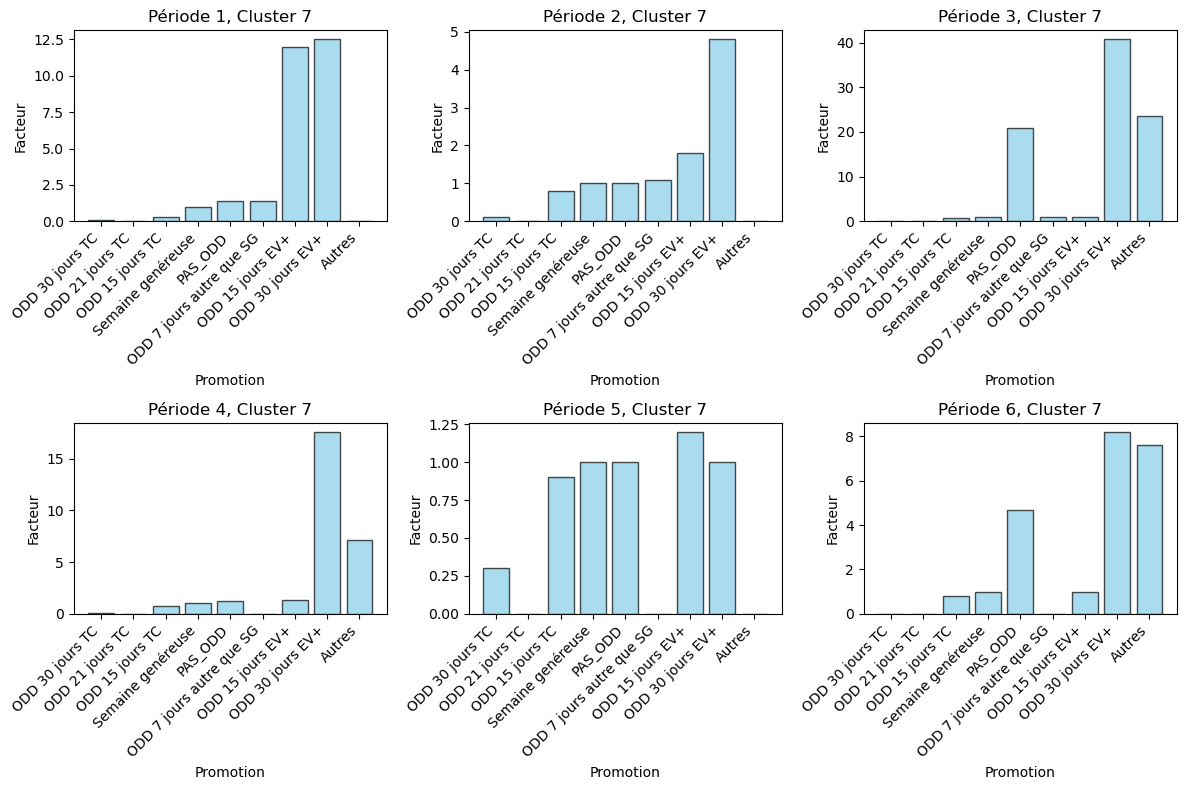

In [23]:
liste_promotions = list(dataset["TYPE_PROMON"].unique())
print(liste_promotions)
liste_clusters = list(range(8))

# Boucler à travers chaque cluster
for cluster in liste_clusters:
    # Créer une figure pour ce cluster
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))

    # Boucler à travers chaque période
    for i, ax in enumerate(axs.flatten(), start=1):
        # Récupérer les valeurs des promotions pour ce cluster et cette période
        valeurs_promotions = [dataset_cluster_explanations.iloc[cluster][f"Facteur d'abonnement pour {promo} sur la période {i}"] for promo in liste_promotions]
        
        # Créer l'histogramme pour ce cluster et cette période
        ax.bar(liste_promotions, valeurs_promotions, color='skyblue', edgecolor='black', alpha=0.7)
        ax.set_title(f'Période {i}, Cluster {cluster}')
        ax.set_xlabel('Promotion')
        ax.set_ylabel('Facteur')

        # Faire pivoter les étiquettes de l'axe x pour une meilleure lisibilité
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Ajuster la disposition pour éviter les chevauchements
    plt.tight_layout()

    # Enregistrer la figure dans un fichier
    nom_fichier_temporaire = f"histogrammes_full_cluster_{cluster}.png"
    plt.savefig(nom_fichier_temporaire)

    # Enregistrer le fichier temporaire sur S3
    with fs.open(BUCKET + 'Batons_full/' + nom_fichier_temporaire, mode='wb') as file_out:
        with open(nom_fichier_temporaire, 'rb') as temp_file:
            file_out.write(temp_file.read())

    # Supprimer le fichier temporaire
    os.remove(nom_fichier_temporaire)

    # Afficher la figure
    plt.show()


[0.0, 0.2448637316561845, 0.3411483641075478, 0.33732601962759806, 0.3588232607007446, 0.3783490566037736]
[0.6908693540553666, 0.550201417571771, 0.5680896271972184, 0.4370940170940171, 0.4597405775819873, 0.5268630849220104]
[0.4029274200283972, 0.38376507744515004, 0.4705891634321058, 0.42605400284225486, 0.47395110670630985, 0.43076628841004716]
[0.638110790101746, 0.5973631178057861, 0.7108356380877123, 0.6265542328042328, 0.689389338731444, 0.6456884561891516]
[0.35348183037320513, 0.2861167940849216, 0.3015029247256735, 0.2641629535327817, 0.2751114033165315, 0.35919540229885055]
[0.0, 0.23632958801498127, 0.5385339276869737, 0.5278483992467043, 0.7337644025461284, 0.6984116390816871]
[0.0, 0.0, 0.16666666666666666, 0.2645631067961165, 0.3894629924041689, 0.523973073224344]
[0.8179775280898877, 0.8233642394090155, 0.8695125135205699, 0.7854266860530142, 0.8420458026960784, 0.8335777126099707]


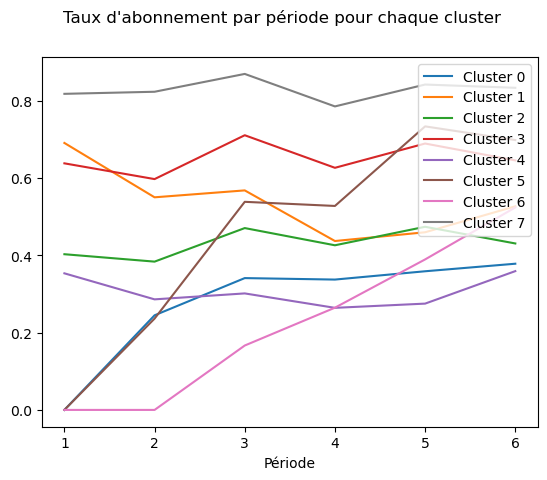

In [ ]:
"""Trace les courbes de taux d'abonnement pour chaque cluster."""
for cluster in range(0, 8, 1):
    X = range(1, 7, 1)

    # Sélectionner la ligne correspondant au cluster 'Cluster1'
    cluster_row = dataset_cluster_explanations.loc[dataset_cluster_explanations['Cluster'] == cluster]
    # Extraire les valeurs des 6 dernières colonnes
    Y = (cluster_row.iloc[:, -6:].values.tolist())[0]
    print(Y)

    plt.plot(X, Y, label = f"Cluster {cluster}")

# Ajouter un titre global et un label pour l'axe x
plt.xlabel("Période")
plt.suptitle("Taux d'abonnement par période pour chaque cluster")
plt.legend(loc='upper right')

# Enregistrer la figure dans un fichier
nom_fichier_temporaire = 'graph_taux_abonnement.png'
plt.savefig(nom_fichier_temporaire)

# Enregistrer le fichier temporaire sur S3
with fs.open(BUCKET + nom_fichier_temporaire, mode='wb') as file_out:
    with open(nom_fichier_temporaire, 'rb') as temp_file:
        file_out.write(temp_file.read())

# Supprimer le fichier temporaire
os.remove(nom_fichier_temporaire)

# Afficher le graphe
plt.show()

In [ ]:
dataset['DATE_PRISE_EFFET'].min(), dataset['DATE_PRISE_EFFET'].max()

('2021-01-01', '2023-10-31')

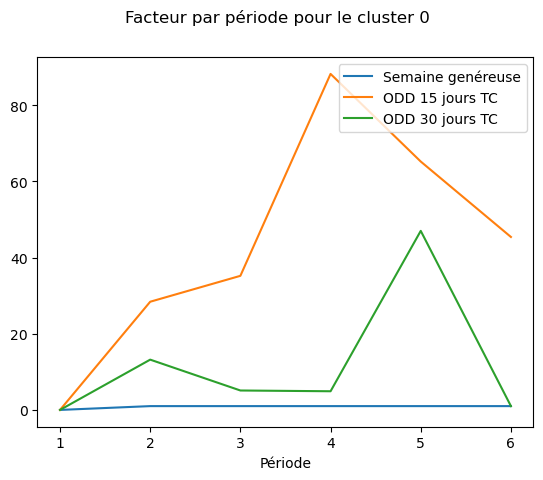

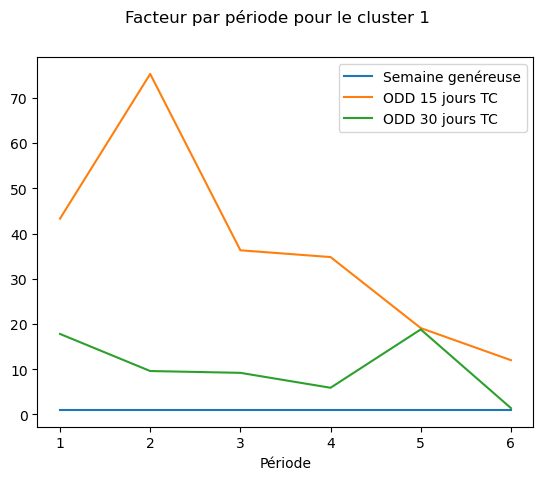

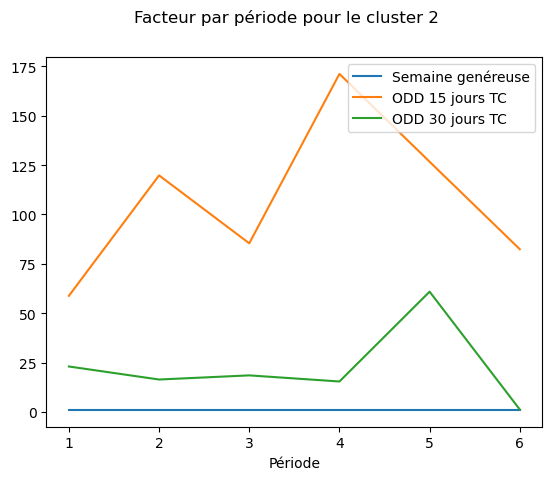

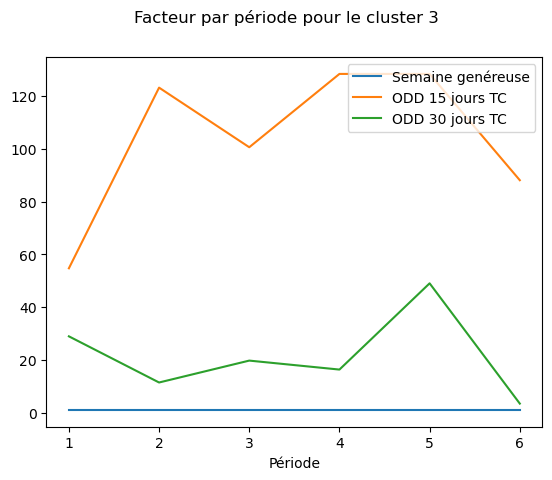

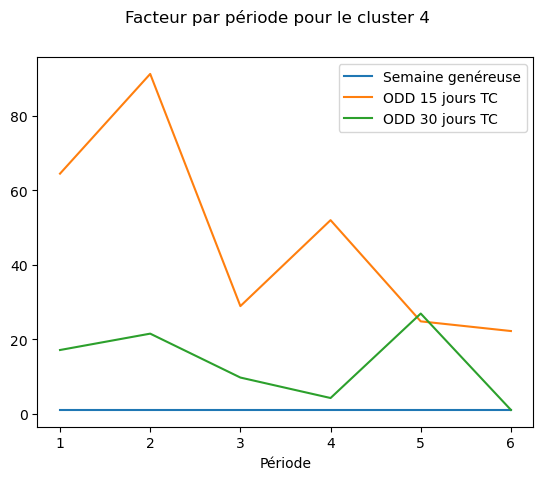

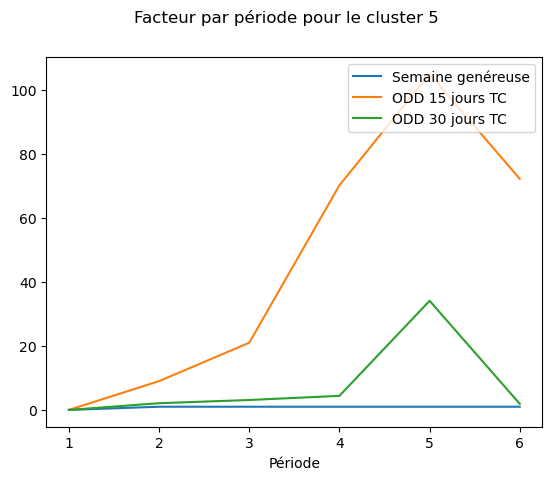

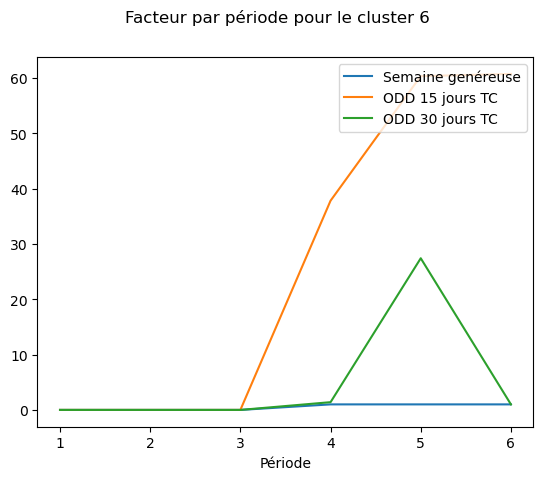

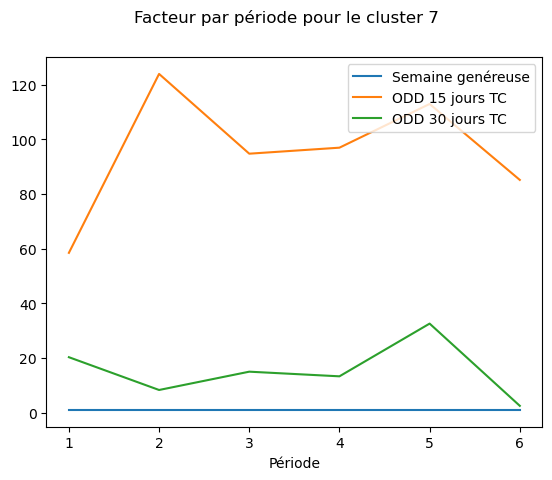

In [35]:
"""Trace les courbes de taux d'abonnement pour chaque cluster."""
for cluster in range(0, 8, 1):
    Y = {}
    for promo in ['Semaine genéreuse', 'ODD 15 jours TC', 'ODD 30 jours TC']:
        X = list(range(1, 7, 1))
        list_columns = [f"Facteur d'abonnement pour {promo} sur la période {i}" for i in X]
        Y[promo] = [dataset_cluster_explanations.iloc[cluster, dataset_cluster_explanations.columns.get_loc(column)] for column in list_columns]
        plt.plot(X, Y[promo], label = promo)

    # Ajouter un titre global et un label pour l'axe x
    plt.xlabel("Période")
    plt.suptitle(f"Facteur par période pour le cluster {cluster}")
    plt.legend(loc='upper right')

    # Enregistrer la figure dans un fichier
    nom_fichier_temporaire = f'Graph_facteurs à travers le temps pour le cluster {cluster}.png'
    plt.savefig(nom_fichier_temporaire)

    # Enregistrer le fichier temporaire sur S3
    with fs.open(BUCKET + nom_fichier_temporaire, mode='wb') as file_out:
        with open(nom_fichier_temporaire, 'rb') as temp_file:
            file_out.write(temp_file.read())

    # Supprimer le fichier temporaire
    os.remove(nom_fichier_temporaire)

    # Afficher le graphe
    plt.show()

In [4]:
df = dataset.copy()

# Convertir la colonne 'DATE_PRISE_EFFET' en type datetime
df['DATE_PRISE_EFFET'] = pd.to_datetime(df['DATE_PRISE_EFFET'])

# Liste des promotions à considérer
liste_promotions = ['Semaine genéreuse', 'ODD 15 jours TC', 'ODD 30 jours TC']

# Initialiser une liste pour stocker les périodes par type de promotion
periodes_par_type = {}

# Parcourir chaque type de promotion dans liste_promotions
for type_promon in liste_promotions:
    # Filtrer le DataFrame pour inclure uniquement les lignes correspondant au type de promotion actuel
    df_type_promon = df[df['TYPE_PROMON'] == type_promon]
    
    # Calculer le nombre d'abonnements par jour
    abonnements_par_jour = df_type_promon.groupby('DATE_PRISE_EFFET').size()
    print(type(abonnements_par_jour))
    
    # Calculer la moyenne et l'écart-type des abonnements par jour
    moyenne = abonnements_par_jour.mean()
    ecart_type = abonnements_par_jour.std()
    
    # Déterminer le seuil pour les abonnements significatifs (95% des valeurs les plus élevées)
    #seuil = abonnements_par_jour.quantile(0.05)
    #seuil = moyenne - 1.96 * ecart_type
    seuil = (1/3) * moyenne 
    
    # Identifier les jours où le nombre d'abonnements est significatif
    jours_significatifs = abonnements_par_jour[abonnements_par_jour >= seuil].index.tolist()
    
    # Identifier les périodes consécutives de jours significatifs
    periodes = []
    periode = []
    for jour in jours_significatifs:
        if not periode or (jour - periode[-1]).days <= 4:
            periode.append(jour)
        else:
            periodes.append(periode)
            periode = [jour]
    if periode:
        periodes.append(periode)

    to_delete = [i for i in range(len(periodes)) if (periodes[i][-1]-periodes[i][0]).days <= 2]
    c = 0
    for i in to_delete:
        del periodes[i-c]
        c += 1
        
    periodes_par_type[type_promon] = periodes

# Afficher les résultats
dico_periodes = {}
for type_promon, periodes in periodes_par_type.items():
    print(f"Type de promotion : {type_promon}")
    print("Périodes significatives :")
    dico_periodes[type_promon] = []
    for periode in periodes:
        print("-", periode[0].strftime("%Y-%m-%d"), "à", periode[-1].strftime("%Y-%m-%d"))
        dico_periodes[type_promon] += [[periode[0].strftime("%Y-%m-%d"), periode[-1].strftime("%Y-%m-%d")]]
    print(dico_periodes)


print (dico_periodes)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
Type de promotion : Semaine genéreuse
Périodes significatives :
- 2021-02-02 à 2021-07-04
- 2021-08-02 à 2021-11-21
- 2022-02-01 à 2022-04-20
- 2022-05-06 à 2022-06-12
- 2022-08-01 à 2022-11-16
- 2023-01-02 à 2023-01-14
- 2023-01-28 à 2023-03-02
- 2023-03-24 à 2023-06-04
- 2023-07-01 à 2023-09-04
- 2023-10-01 à 2023-10-30
{'Semaine genéreuse': [['2021-02-02', '2021-07-04'], ['2021-08-02', '2021-11-21'], ['2022-02-01', '2022-04-20'], ['2022-05-06', '2022-06-12'], ['2022-08-01', '2022-11-16'], ['2023-01-02', '2023-01-14'], ['2023-01-28', '2023-03-02'], ['2023-03-24', '2023-06-04'], ['2023-07-01', '2023-09-04'], ['2023-10-01', '2023-10-30']]}
Type de promotion : ODD 15 jours TC
Périodes significatives :
- 2021-01-01 à 2021-02-07
- 2021-06-15 à 2021-08-03
- 2021-11-19 à 2022-02-08
- 2022-04-14 à 2022-05-12
- 2022-07-01 à 2022-08-03
- 2022-11-10 à 2023-01-01
- 2023-01-10 à 2023-01-27


In [5]:
# Votre dictionnaire
mon_dictionnaire = dico_periodes.copy()
if 'ODD 30 jours TC' in mon_dictionnaire:
    del mon_dictionnaire['ODD 30 jours TC']

print(mon_dictionnaire)

# Enregistrer la figure dans un fichier
nom_fichier_temporaire = 'read_me.txt'
# Enregistrer le fichier temporaire sur S3
with open(nom_fichier_temporaire, 'w') as fichier:
    # Écrire le dictionnaire dans le fichier au format JSON
    json.dump(mon_dictionnaire, fichier)
    
    # Ajouter des informations supplémentaires
    fichier.write("\n")
    fichier.write("Nous avons calculé des Périodes d'utilisation massives des ODD.\n")
    fichier.write("Pour ODD15JTC et Semaine Généreuse, nous avons calculé des périodes sur lesquelles l'offre est massivement utilisée.\n")
    fichier.write("\n")
    fichier.write("Les Périodes sont calculées de la sorte :\n")
    fichier.write("    On considère comme période un ensemble de jours consécutifs pendant lesquels l'offre est significative au minimum tous les 4 jours.\n")
    fichier.write("    L'offre est significative au jour j si le nombre d'abonnements faits le jour J est supérieur à 1/3 de la moyenne. C'est une façon de se préserver\n")
    fichier.write("    des faibles utilisations qui relèvent de très petites cibles.\n")
    fichier.write("    En d'autres termes, sur une période, l'offre est utilisée en continue, mais il peut y avoir des creux de faible utilisation d'une durée maximale de 4 jours.\n")
    fichier.write("    Si un creux dépasse les 4 jours, alors la période s'arrête.\n")

    fichier.write("\n")
    fichier.write("Les Périodes sont ensuite utilisées de la façon suivante pour calculer notre indicateur:\n")
    fichier.write("    Prenons une période P d'utilisation d'ODD 15J TC. Notons P* et P** les périodes d'utilisation de Semaine Généreuse, respectivement\n")
    fichier.write("    la période la plus proche de P qui la précède et la plus proche de P qui la succède.\n")
    fichier.write("    Ensuite, on compare le nombre d'abonnement moyen sur P au nombre d'abonnement moyen sur P* et P**.\n")
    fichier.write("    En d'autres termes, on compare le nombre d'abonnements sur une période de promotions P au nombre d'abonnements sur les périodes de simple\n")
    fichier.write("    Semaine Généreuse qui entourent P.\n")
    fichier.write("\n")
    fichier.write("On obtient ainsi un indicateur appelé Facteur ODD-15JTC Periode i qui représente, dit d'une façon plus qualitative :\n")
    fichier.write("    Le facteur de réabonnement induit par l'usage d'une période d'ODD 15J TC.\n")

# Enregistrer le fichier temporaire sur S3
with fs.open(BUCKET + 'Periodes revues/' + nom_fichier_temporaire, mode='wb') as file_out:
    with open(nom_fichier_temporaire, 'rb') as fichier:
        # Copier le contenu du fichier local vers le fichier sur S3
        file_out.write(fichier.read())

# Supprimer le fichier temporaire local
os.remove(nom_fichier_temporaire)




{'Semaine genéreuse': [['2021-02-02', '2021-07-04'], ['2021-08-02', '2021-11-21'], ['2022-02-01', '2022-04-20'], ['2022-05-06', '2022-06-12'], ['2022-08-01', '2022-11-16'], ['2023-01-02', '2023-01-14'], ['2023-01-28', '2023-03-02'], ['2023-03-24', '2023-06-04'], ['2023-07-01', '2023-09-04'], ['2023-10-01', '2023-10-30']], 'ODD 15 jours TC': [['2021-01-01', '2021-02-07'], ['2021-06-15', '2021-08-03'], ['2021-11-19', '2022-02-08'], ['2022-04-14', '2022-05-12'], ['2022-07-01', '2022-08-03'], ['2022-11-10', '2023-01-01'], ['2023-01-10', '2023-01-27'], ['2023-02-24', '2023-04-17'], ['2023-05-25', '2023-07-06'], ['2023-08-25', '2023-10-07']]}


In [33]:
from datetime import datetime, timedelta

# Exemple de dictionnaire de périodes
dico_periodes = {
    "promo1": [[datetime(2024, 1, 1), datetime(2024, 1, 5)], [datetime(2024, 1, 6), datetime(2024, 1, 10)]],
    "promo2": [[datetime(2024, 2, 1), datetime(2024, 2, 5)], [datetime(2024, 2, 6), datetime(2024, 2, 10)]]
}

# Transformer les périodes selon les règles spécifiées
type_promon = "promo1"
for i in range(len(dico_periodes[type_promon]) - 1):
    debut_suivant = dico_periodes[type_promon][i + 1][0]
    fin_actuelle = dico_periodes[type_promon][i][1]
    difference = (debut_suivant - fin_actuelle) / 2
    jour_milieu = fin_actuelle + difference
    dico_periodes[type_promon][i][1] = jour_milieu

# Afficher les périodes mises à jour
print(dico_periodes)

{'promo1': [[datetime.datetime(2024, 1, 1, 0, 0), datetime.datetime(2024, 1, 5, 12, 0)], [datetime.datetime(2024, 1, 6, 0, 0), datetime.datetime(2024, 1, 10, 0, 0)]], 'promo2': [[datetime.datetime(2024, 2, 1, 0, 0), datetime.datetime(2024, 2, 5, 0, 0)], [datetime.datetime(2024, 2, 6, 0, 0), datetime.datetime(2024, 2, 10, 0, 0)]]}


In [12]:
liste_promotions = ['Semaine genéreuse', 'ODD 15 jours TC', 'ODD 30 jours TC']

def fonction_ODD_15(group, dic_periods, cluster, type_promo, nombre_reabo_par_jour_dispo):
    cluster_abonnements_moyens = {}
    for i, (debut_periode, fin_periode) in enumerate(dic_periods['ODD 15 jours TC'], start=1):
        periode_data = group[(group['DATE_PRISE_EFFET'] >= debut_periode) & (group['DATE_PRISE_EFFET'] < fin_periode)]
        abonnements_periode = len(periode_data)
        dates_diff = periode_data['DATE_PRISE_EFFET'].nunique()
        if dates_diff > 0:
            abonnements_moyens_periode = abonnements_periode / dates_diff
        else:
            abonnements_moyens_periode = 0
        cluster_abonnements_moyens[f'Période {i}'] = abonnements_moyens_periode
    if cluster not in nombre_reabo_par_jour_dispo:
        nombre_reabo_par_jour_dispo[cluster] = {}
    nombre_reabo_par_jour_dispo[cluster][type_promo] = cluster_abonnements_moyens
    return nombre_reabo_par_jour_dispo

def fonction_SG(group, dic_periods, cluster, type_promo, nombre_reabo_par_jour_dispo):
    # Parcourir chaque période de 'ODD 15 jours TC'
    liste_SG = []
    for periode_ODD in dic_periods['ODD 15 jours TC']:
        # Initialiser les périodes précédente et suivante avec None
        periode_precedente = None
        periode_suivante = None
        print('dicoSG = ',dic_periods['Semaine genéreuse']) 
        
        # Parcourir chaque période de 'Semaine genéreuse'
        for periode_SG in dic_periods['Semaine genéreuse']:
            # Si la période de 'Semaine genéreuse' est avant la période de 'ODD 15 jours TC'
            print('periode_SG[-1] <= periode_ODD[0] and periode_SG[-1] <= periode_ODD[1] ? Voyons : ', periode_SG[-1] <= periode_ODD[0], periode_SG[-1] <= periode_ODD[1])
            if periode_SG[-1] < periode_ODD[-1] and periode_SG[0] < periode_ODD[0]:
                periode_precedente = periode_SG
            # Si la période de 'Semaine genéreuse' est après la période de 'ODD 15 jours TC'
            elif periode_SG[0] > periode_ODD[0] and periode_SG[-1] > periode_ODD[-1]:
                periode_suivante = periode_SG
                break  # On peut arrêter la recherche car les périodes sont triées par ordre croissant
            
        # Ajouter les résultats à liste_SG
        liste_SG.append([periode_precedente, periode_suivante])
    print('liste_SG = ', liste_SG)
    # Afficher les résultats
    for i, (periode_ODD, (periode_precedente, periode_suivante)) in enumerate(zip(dic_periods['ODD 15 jours TC'], liste_SG)):
        print(f"Période ODD {i+1}: {periode_ODD}")
        print(f"Période précédente SG: {periode_precedente}")
        print(f"Période suivante SG: {periode_suivante}")
        print()
    
    cluster_abonnements_moyens = {}

    for i, list_sg in enumerate(liste_SG, start=1):
        print(type(None))
        print(list_sg[1])
        print([None,None])
        if list_sg[0] == None:
            debut_periode1 = None
            fin_periode1 = None
            debut_periode2 = list_sg[1][0]
            fin_periode2 = list_sg[1][1]
        elif list_sg[1] == None:
            debut_periode1 = list_sg[0][0]
            fin_periode1 = list_sg[0][1]
            debut_periode2 = None
            fin_periode2 = None
        else:
            debut_periode1 = list_sg[0][0]
            fin_periode1 = list_sg[0][1]
            debut_periode2 = list_sg[1][0]
            fin_periode2 = list_sg[1][1]

        if fin_periode1 == None :
            periode_data = group[(group['DATE_PRISE_EFFET'] >= debut_periode2) & (group['DATE_PRISE_EFFET'] < fin_periode2)]
        elif debut_periode2 == None :
            periode_data = group[(group['DATE_PRISE_EFFET'] >= debut_periode1) & (group['DATE_PRISE_EFFET'] < fin_periode1)]
        else :
            periode_data = group[((group['DATE_PRISE_EFFET'] >= debut_periode1) & (group['DATE_PRISE_EFFET'] < fin_periode1)) | ((group['DATE_PRISE_EFFET'] >= debut_periode2) & (group['DATE_PRISE_EFFET'] < fin_periode2))]

        abonnements_periode = len(periode_data)
        dates_diff = periode_data['DATE_PRISE_EFFET'].nunique()
        if dates_diff > 0:
            abonnements_moyens_periode = abonnements_periode / dates_diff
        else:
            abonnements_moyens_periode = 0
        cluster_abonnements_moyens[f'Période {i}'] = abonnements_moyens_periode
    if cluster not in nombre_reabo_par_jour_dispo:
        nombre_reabo_par_jour_dispo[cluster] = {}
    nombre_reabo_par_jour_dispo[cluster][type_promo] = cluster_abonnements_moyens
    return nombre_reabo_par_jour_dispo

liste_promotions = ['Semaine genéreuse', 'ODD 15 jours TC', 'ODD 30 jours TC']

def find_mean_with_promo_periods_(df, dic_periods):
    """ Returns aa dictionnary """
    print(dic_periods)
    data = df.copy()
    data['DATE_PRISE_EFFET'] = pd.to_datetime(data['DATE_PRISE_EFFET'])

    # Grouper les données par CLUSTER_8, TYPE_PROMON et Période
    nombre_reabo_par_jour_dispo = {}
    for (cluster, type_promo), group in data.groupby(['Cluster_8', 'TYPE_PROMON']):
        if type_promo == 'Semaine genéreuse':
            nombre_reabo_par_jour_dispo = fonction_SG(group, dic_periods, cluster, type_promo, nombre_reabo_par_jour_dispo)
        elif type_promo == 'ODD 15 jours TC':
            nombre_reabo_par_jour_dispo = fonction_ODD_15(group, dic_periods, cluster, type_promo, nombre_reabo_par_jour_dispo)
        elif type_promo == 'ODD 30 jours TC':
            continue
        else :
            continue


    # Afficher les résultats
    for cluster, resultats_periode in nombre_reabo_par_jour_dispo.items():
        print(f"Cluster {cluster}:")
        for type_promo, resultats_periode_type in resultats_periode.items():
            print(f"  - Type promotion {type_promo}:")
            for periode, moyenne in resultats_periode_type.items():
                print(f"      Période {periode}: Nombre de réabonnements moyens par jour de disponibilité : {moyenne}")
    return nombre_reabo_par_jour_dispo

# Appeler la fonction pour calculer les abonnements moyens
find_mean_with_promo_periods_(dataset, dico_periodes)

{'Semaine genéreuse': [['2021-02-02', '2021-07-04'], ['2021-08-02', '2021-11-21'], ['2022-02-01', '2022-04-20'], ['2022-05-06', '2022-06-12'], ['2022-08-01', '2022-11-16'], ['2023-01-02', '2023-01-14'], ['2023-01-28', '2023-03-02'], ['2023-03-24', '2023-06-04'], ['2023-07-01', '2023-09-04'], ['2023-10-01', '2023-10-30']], 'ODD 15 jours TC': [['2021-01-01', '2021-02-07'], ['2021-06-15', '2021-08-03'], ['2021-11-19', '2022-02-08'], ['2022-04-14', '2022-05-12'], ['2022-07-01', '2022-08-03'], ['2022-11-10', '2023-01-01'], ['2023-01-10', '2023-01-27'], ['2023-02-24', '2023-04-17'], ['2023-05-25', '2023-07-06'], ['2023-08-25', '2023-10-07']], 'ODD 30 jours TC': [['2021-06-01', '2021-08-02'], ['2021-12-03', '2021-12-31'], ['2022-02-01', '2022-03-03'], ['2022-06-01', '2022-07-03'], ['2022-08-01', '2022-09-04'], ['2022-12-23', '2023-01-23']]}
dicoSG =  [['2021-02-02', '2021-07-04'], ['2021-08-02', '2021-11-21'], ['2022-02-01', '2022-04-20'], ['2022-05-06', '2022-06-12'], ['2022-08-01', '2022-11

{0: {'ODD 15 jours TC': {'Période 1': 0,
   'Période 2': 2.0,
   'Période 3': 42.074074074074076,
   'Période 4': 99.35714285714286,
   'Période 5': 118.51515151515152,
   'Période 6': 121.88461538461539,
   'Période 7': 82.41176470588235,
   'Période 8': 101.98076923076923,
   'Période 9': 79.92857142857143,
   'Période 10': 75.69767441860465},
  'Semaine genéreuse': {'Période 1': 0,
   'Période 2': 4.6419753086419755,
   'Période 3': 19.426751592356688,
   'Période 4': 32.36283185840708,
   'Période 5': 29.59027777777778,
   'Période 6': 29.369747899159663,
   'Période 7': 21.044444444444444,
   'Période 8': 21.059405940594058,
   'Période 9': 18.345864661654137,
   'Période 10': 16.085106382978722}},
 1: {'ODD 15 jours TC': {'Période 1': 129.9189189189189,
   'Période 2': 91.12244897959184,
   'Période 3': 88.01234567901234,
   'Période 4': 60.07142857142857,
   'Période 5': 42.03030303030303,
   'Période 6': 43.46153846153846,
   'Période 7': 19.470588235294116,
   'Période 8': 31.

In [7]:
def calculate_abonnements_moyens(datata, periods):
    """Calcule le nombre d'abonnements moyens par jour de disponibilité pour chaque cluster sur chaque période."""
    df = datata.copy()
    df['DATE_PRISE_EFFET'] = pd.to_datetime(df['DATE_PRISE_EFFET'])
    nombre_abonnements_moyens = {}
    for cluster, group in df.groupby('Cluster_8'):
        cluster_abonnements_moyens = {}
        for i, (debut_periode, fin_periode) in enumerate(periods, start=1):
            print('Cluster ', cluster, 'période ', i, (debut_periode, fin_periode))
            periode_data = group[(group['DATE_PRISE_EFFET'] >= debut_periode) & (group['DATE_PRISE_EFFET'] < fin_periode)]
            #abonnements_periode = periode_data.groupby('ID_ABONNE')['DATE_PRISE_EFFET'].nunique().count()
            abonnements_periode = periode_data.shape[0]
            print('abonnements_periode :',abonnements_periode)
            if i < 6:
                jours_disponibilite = 6 * periode_data['ID_ABONNE'].nunique()
            elif i == 6:
                jours_disponibilite = 4 * periode_data['ID_ABONNE'].nunique()

            print('jours_disponibilite : ', jours_disponibilite)
            if jours_disponibilite > 0:
                abonnements_moyens_periode = abonnements_periode / jours_disponibilite
            else:
                abonnements_moyens_periode = 0
            cluster_abonnements_moyens[f'Période {i}'] = abonnements_moyens_periode
        nombre_abonnements_moyens[cluster] = cluster_abonnements_moyens
    return nombre_abonnements_moyens


In [13]:
dataset_cluster_explanations = pd.DataFrame({'Cluster': list(range(8))})
print(dataset_cluster_explanations)

dataset_cluster_explanations['Pourcentage de la population'] = dataset_cluster_explanations['Cluster'].map(find_percent(dataset))
dataset_cluster_explanations['Dico'] = dataset_cluster_explanations['Cluster'].map(find_mean_with_promo_periods_(dataset, dico_periodes))
print(dataset['TYPE_PROMON'].unique())
list_promo = ['Semaine genéreuse', 'ODD 15 jours TC']#, 'ODD 30 jours TC']
for i in range(1, 11, 1):
    for promo in list_promo:
        dataset_cluster_explanations[f"Facteur d'abonnement pour {promo} sur la période {i}"] = dataset_cluster_explanations["Dico"].apply(lambda x: x[promo][f"Période {i}"])
        print(dataset_cluster_explanations[f"Facteur d'abonnement pour {promo} sur la période {i}"])



list_promo = ['ODD 15 jours TC']
for promo in list_promo:
    for i in range(1, 11, 1):
        if not dataset_cluster_explanations[f"Facteur d'abonnement pour Semaine genéreuse sur la période {i}"].empty :
            dataset_cluster_explanations[f"Facteur d'abonnement pour {promo} sur la période {i}"] = dataset_cluster_explanations[f"Facteur d'abonnement pour {promo} sur la période {i}"] / dataset_cluster_explanations[f"Facteur d'abonnement pour Semaine genéreuse sur la période {i}"]
        else :
            dataset_cluster_explanations[f"Facteur d'abonnement pour {promo} sur la période {i}"] = float('inf')

for i in range(1, 11, 1):
    dataset_cluster_explanations.drop(columns = [f"Facteur d'abonnement pour Semaine genéreuse sur la période {i}"], inplace = True)
    dataset_cluster_explanations.rename(columns={f"Facteur d'abonnement pour ODD 15 jours TC sur la période {i}" : f"Facteur ODD-15JTC Periode {i}"}, inplace = True)

dataset_cluster_explanations.drop(columns = ['Dico'], inplace = True)

"""
dataset_cluster_explanations["Periods"] = dataset_cluster_explanations['Cluster'].map(calculate_abonnements_moyens(dataset, periods))
print(dataset_cluster_explanations)
for i in range(1, 7, 1):
    dataset_cluster_explanations[f"Taux d'abonnement sur la période {i}"] = dataset_cluster_explanations["Periods"].apply(lambda x: x[f"Période {i}"])
dataset_cluster_explanations.drop(columns = ['Periods'], inplace = True)
"""
dataset_cluster_explanations = dataset_cluster_explanations.fillna(0)
dataset_cluster_explanations = dataset_cluster_explanations.round(1)



# Enregistrer la figure dans un fichier
nom_fichier_temporaire = 'clusters_explanation_ODD15JTC.csv'
dataset_cluster_explanations.to_csv(nom_fichier_temporaire, index=False)
# Enregistrer le fichier temporaire sur S3
with fs.open(BUCKET + 'Periodes revues/' + nom_fichier_temporaire, mode='wb') as file_out:
    with open(nom_fichier_temporaire, 'rb') as temp_file:
        file_out.write(temp_file.read())
# Supprimer le fichier temporaire
os.remove(nom_fichier_temporaire)

dataset_cluster_explanations_shortened = dataset_cluster_explanations.copy()
dataset_cluster_explanations_shortened

   Cluster
0        0
1        1
2        2
3        3
4        4
5        5
6        6
7        7
Cluster 0: 13.45%
Cluster 1: 9.04%
Cluster 2: 14.02%
Cluster 3: 13.07%
Cluster 4: 16.04%
Cluster 5: 10.96%
Cluster 6: 11.96%
Cluster 7: 11.47%
{'Semaine genéreuse': [['2021-02-02', '2021-07-04'], ['2021-08-02', '2021-11-21'], ['2022-02-01', '2022-04-20'], ['2022-05-06', '2022-06-12'], ['2022-08-01', '2022-11-16'], ['2023-01-02', '2023-01-14'], ['2023-01-28', '2023-03-02'], ['2023-03-24', '2023-06-04'], ['2023-07-01', '2023-09-04'], ['2023-10-01', '2023-10-30']], 'ODD 15 jours TC': [['2021-01-01', '2021-02-07'], ['2021-06-15', '2021-08-03'], ['2021-11-19', '2022-02-08'], ['2022-04-14', '2022-05-12'], ['2022-07-01', '2022-08-03'], ['2022-11-10', '2023-01-01'], ['2023-01-10', '2023-01-27'], ['2023-02-24', '2023-04-17'], ['2023-05-25', '2023-07-06'], ['2023-08-25', '2023-10-07']], 'ODD 30 jours TC': [['2021-06-01', '2021-08-02'], ['2021-12-03', '2021-12-31'], ['2022-02-01', '2022-03-03'], ['2

,Cluster,Pourcentage de la population,Facteur ODD-15JTC Periode 1,Facteur ODD-15JTC Periode 2,Facteur ODD-15JTC Periode 3,Facteur ODD-15JTC Periode 4,Facteur ODD-15JTC Periode 5,Facteur ODD-15JTC Periode 6,Facteur ODD-15JTC Periode 7,Facteur ODD-15JTC Periode 8,Facteur ODD-15JTC Periode 9,Facteur ODD-15JTC Periode 10
0,0,13.4,0.0,0.4,2.2,3.1,4.0,4.2,3.9,4.8,4.4,4.7
1,1,9.0,1.1,0.8,1.0,0.9,0.9,1.1,0.7,1.3,1.2,1.1
2,2,14.0,3.5,3.8,3.4,4.3,4.5,5.2,5.0,5.1,5.1,5.0
3,3,13.1,1.4,1.1,1.5,1.5,1.1,1.6,1.5,1.7,1.9,1.8
4,4,16.0,3.0,3.1,2.0,3.1,4.2,4.3,3.2,4.3,3.4,3.6
5,5,11.0,0.0,0.0,0.7,1.6,0.9,1.9,1.3,1.5,1.6,1.5
6,6,12.0,0.0,0.0,0.0,0.0,0.2,6.2,3.0,2.5,2.6,2.5
7,7,11.5,0.9,0.6,1.0,0.9,0.6,0.9,0.8,1.1,1.2,1.2


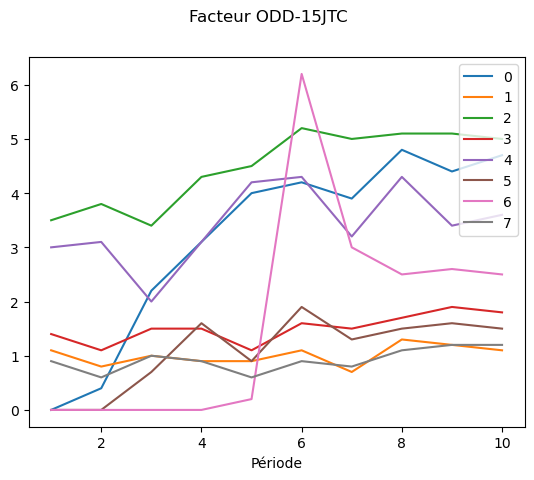

In [14]:
"""Trace les courbes de taux d'abonnement pour chaque cluster."""
for cluster in range(0, 8, 1):
    X = list(range(1, 11, 1))
    list_columns = [f"Facteur ODD-15JTC Periode {i}" for i in X]
    Y = [dataset_cluster_explanations_shortened.iloc[cluster, dataset_cluster_explanations_shortened.columns.get_loc(column)] for column in list_columns]
    plt.plot(X, Y, label = cluster)

# Ajouter un titre global et un label pour l'axe x
plt.xlabel("Période")
plt.suptitle("Facteur ODD-15JTC")
plt.legend(loc='upper right')

# Enregistrer la figure dans un fichier
nom_fichier_temporaire = 'Facteur ODD-15JTC.png'
plt.savefig(nom_fichier_temporaire)

# Enregistrer le fichier temporaire sur S3
with fs.open(BUCKET + 'Periodes revues/' + nom_fichier_temporaire, mode='wb') as file_out:
    with open(nom_fichier_temporaire, 'rb') as temp_file:
        file_out.write(temp_file.read())

# Supprimer le fichier temporaire
os.remove(nom_fichier_temporaire)

# Afficher le graphe
plt.show()